# Preprocessing of Single-cell RNA Sequencing data
Prediction: combined adata resulting from ICTOP on exercise dataset  
Julia Kuhn

In [28]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import anndata

from statsmodels.stats.multitest import multipletests
from scipy.stats import median_abs_deviation
from scipy import stats
from scipy.stats import wilcoxon

In [2]:
# open count matrices
file = "predictedAnndata.h5ad"
adata = sc.read_h5ad(file)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 104883 × 27915
    obs: 'sample_set', 'cellranger_vdj_t', 'cellranger_vdj_b', 'vdj_type', 'yahd', 'sample_name', 'cells', 'experiment_day', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'log1p_total_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'demultiplexing_method', 'cell_ranger', 'agreement', 'detailed_agreement', 'final_demultiplexing', 'Doublet_finder', 'celltypist_cell_label_coarse', 'timepoint', 'participant', 'Predicted_tissue', 'celltype_model'
    obsm: 'Multiplexing Capture', 'cellranger_multi', 'vireo', 'yahd'
    layers: 'counts'

In [3]:
# dataframe for plotting the distributions per timepoint
df = adata.obs[['celltype_model', 'Predicted_tissue', 'timepoint']]
counts = df.groupby(['celltype_model', 'Predicted_tissue', 'timepoint']).size().reset_index(name='counts')

# normlizing number of cells per celltype and timepoint
timepoint_sums = counts.groupby(['celltype_model', 'timepoint'])['counts'].transform('sum')
counts['normalized_counts'] = counts['counts'] / timepoint_sums
counts['normalized_counts'] = counts['normalized_counts']

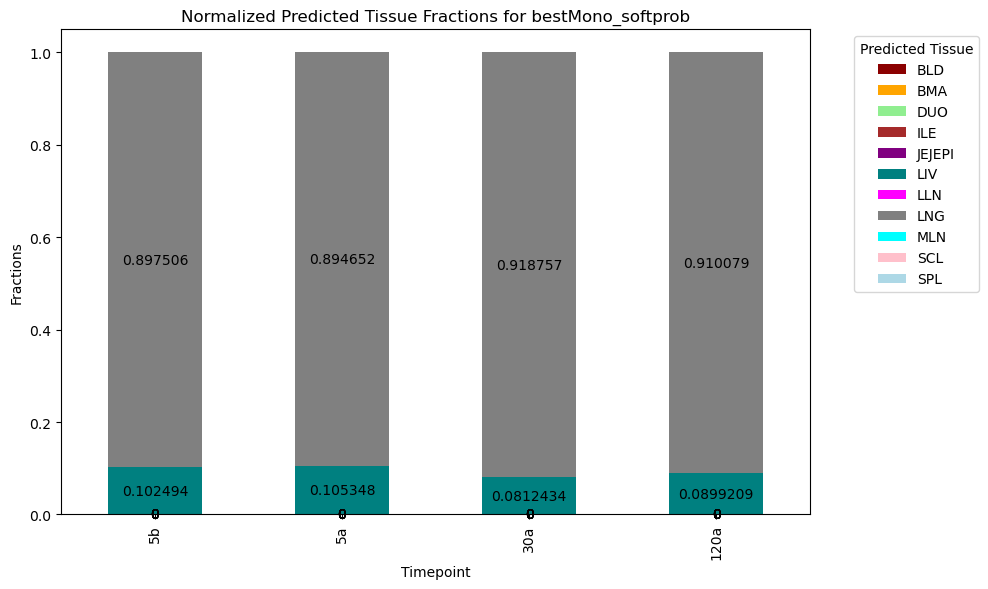

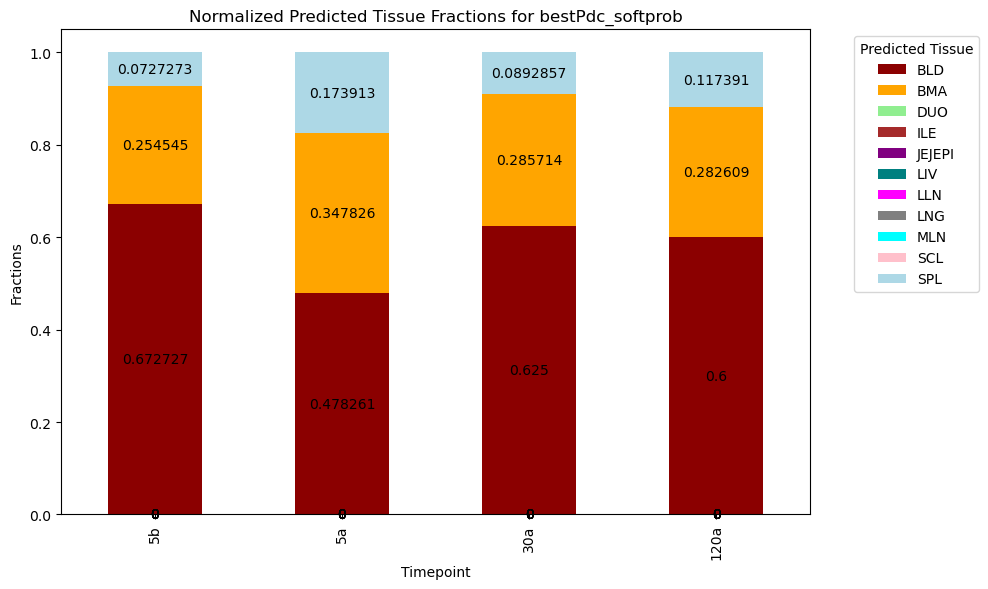

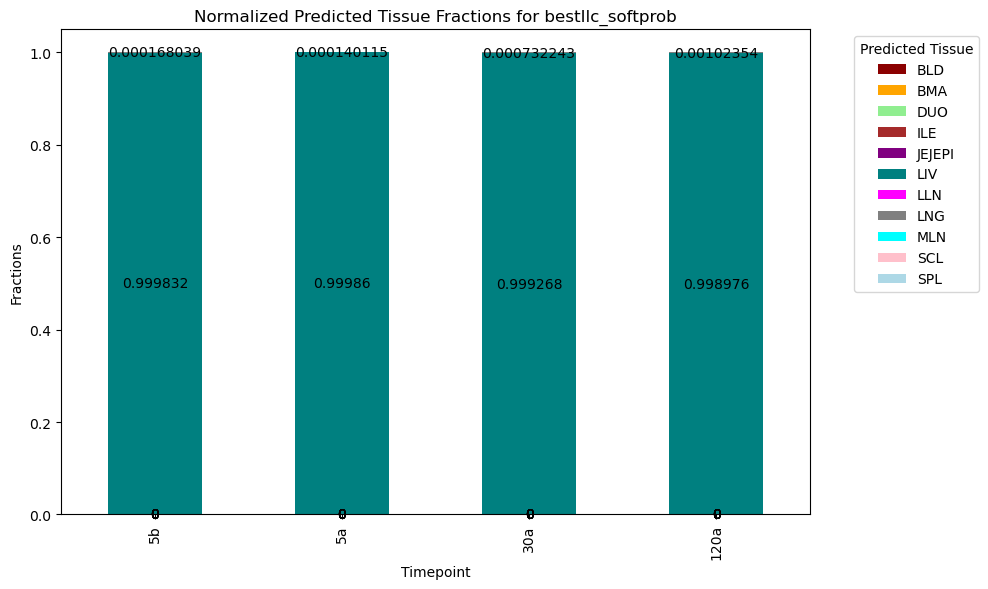

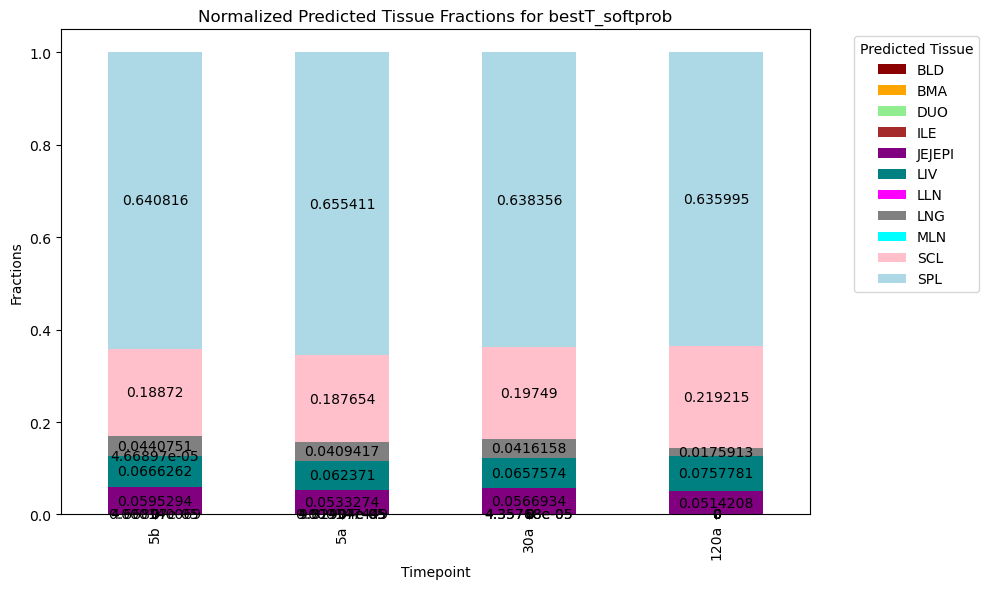

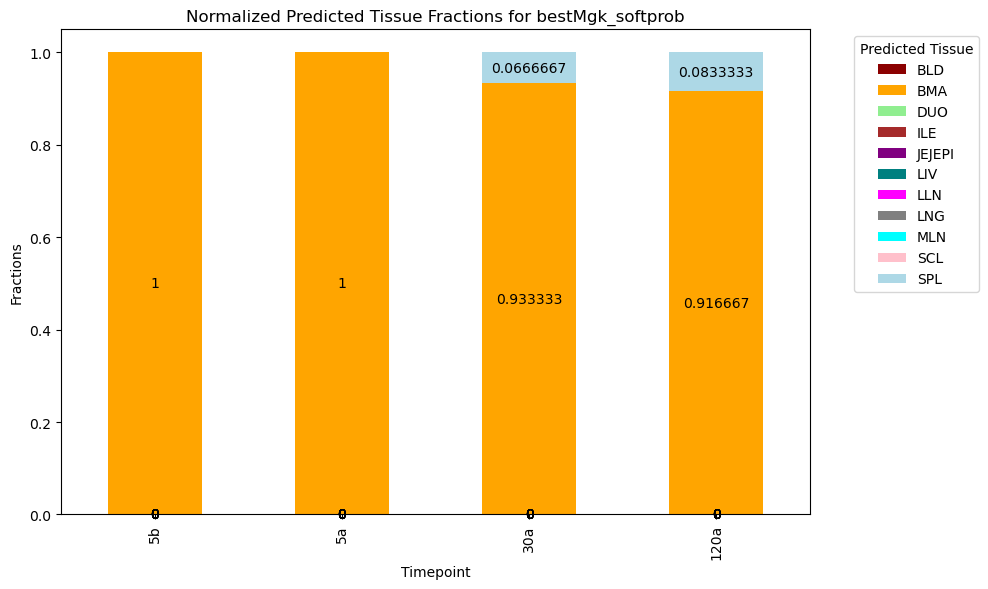

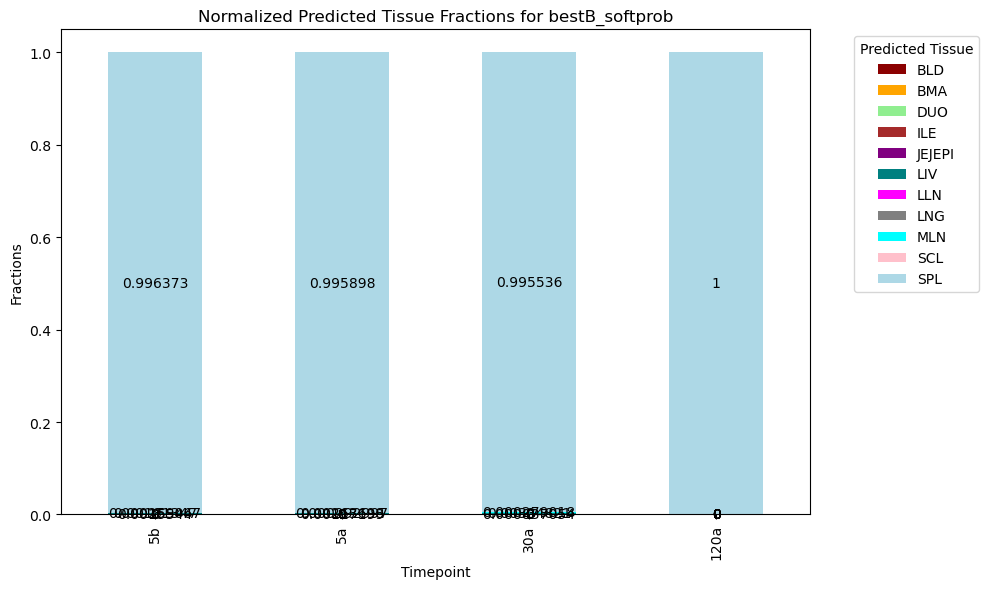

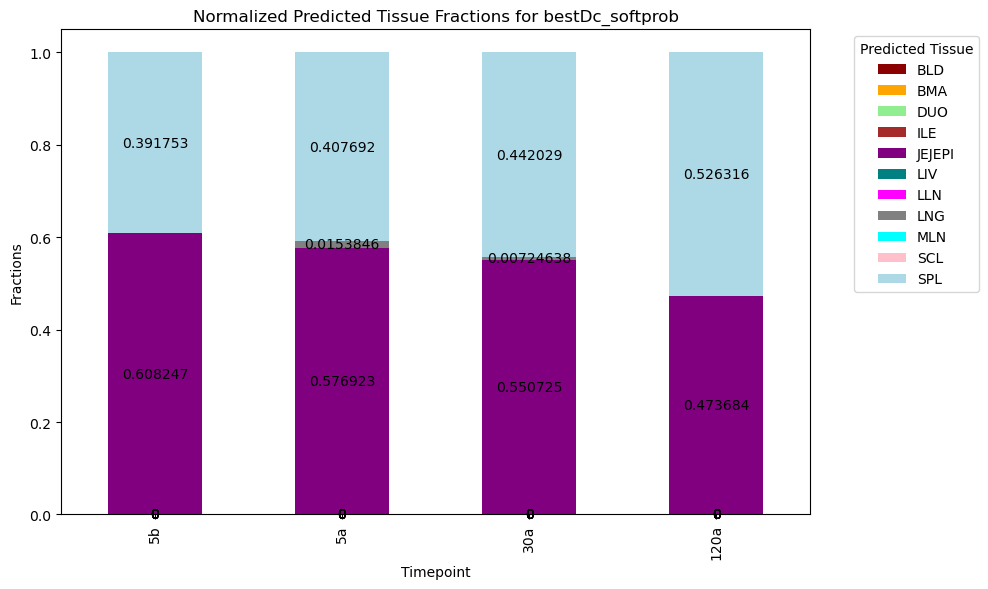

In [4]:
custom_palette = {
    'BLD': 'darkred',
    'SPL': 'lightblue',
    'BMA': 'orange',
    'DUO': 'lightgreen',
    'ILE': 'brown',
    'JEJEPI': 'purple',
    'LIV': 'teal',
    'LLN': 'magenta',
    'LNG': 'grey',
    'MLN': 'cyan',
    'SCL': 'pink',
    'SKM': 'lime',
    
}


for celltype in adata.obs['celltype_model'].unique():
    subset = counts[counts['celltype_model'] == celltype]
    pivot_table = subset.pivot_table(index='timepoint', columns='Predicted_tissue', values='normalized_counts', aggfunc='sum').fillna(0)

    colors = [custom_palette.get(x, 'gray') for x in pivot_table.columns]
    desired_order = ['5b', '5a', '30a', '120a']
    pivot_table = pivot_table.reindex(desired_order)
    
    ax = pivot_table.plot(kind='bar', stacked=True, figsize=(10, 6), color=colors)
    
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

    plt.title(f'Normalized Predicted Tissue Fractions for {celltype}')
    plt.xlabel('Timepoint')
    plt.ylabel('Fractions')
    plt.legend(title='Predicted Tissue', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    

In [5]:
# Perform highly variable genes analysis
sc.pp.highly_variable_genes(adata, n_top_genes=1000, inplace=True)

# Extract the top 2,000 HVGs
top_hvgs = adata.var_names[adata.var['highly_variable']]

# Get the names of the 5 highest and 5 lowest HVGs
highest_hvgs = top_hvgs[:5].tolist()
lowest_hvgs = top_hvgs[-5:].tolist()

# Print the results
print("The top 5 Highly Variable Genes are:")
print(highest_hvgs)

print("\n The bottom 5 Highly Variable Genes are:")
print(lowest_hvgs)

The top 5 Highly Variable Genes are:
['TFPI', 'PRKAR2B', 'ITGA2B', 'CD79B', 'TKTL1']

 The bottom 5 Highly Variable Genes are:
['AC021148.2', 'AC011029.1', 'AC005081.1', 'AL132986.1', 'AC026329.1']


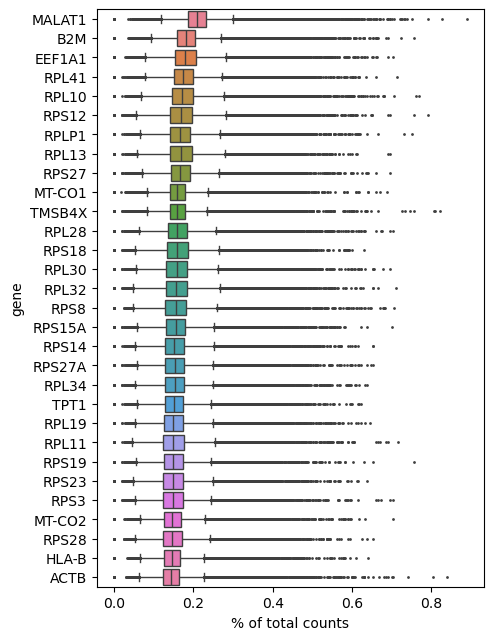

In [6]:
# Visualization: the genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=30)

# Principal Component Analyis (PCA) for Dimensionality Reduction

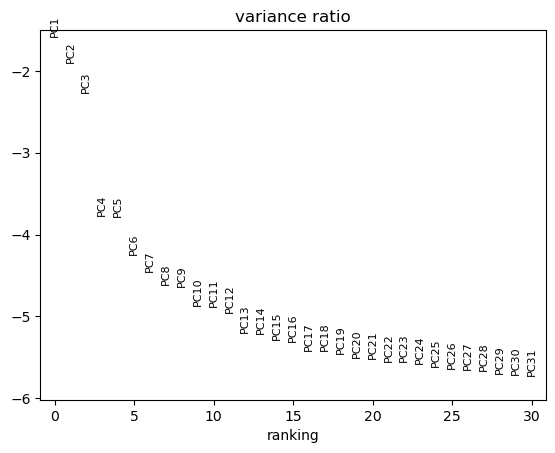

In [7]:
pca_adata = adata.copy()
sc.tl.pca(pca_adata)
# Elbow plot
sc.pl.pca_variance_ratio(pca_adata, log=True, n_pcs=30)

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


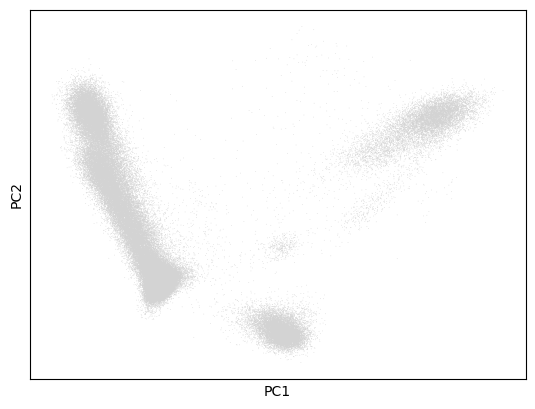

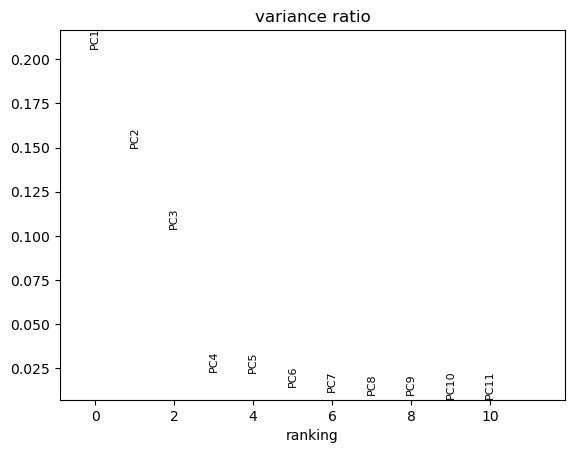

In [8]:
sc.tl.pca(adata, n_comps=11) # Perform PCA
sc.pl.pca(adata) # Plot only the top two principal components as they are most informative
sc.pl.pca_variance_ratio(adata, n_pcs=11)

# Clustering

In [9]:
# KNN calculation
sc.pp.neighbors(adata, n_pcs=11)
sc.tl.leiden(adata)
sc.tl.umap(adata)

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/umap/d

# Visualizations

## UMAPS

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


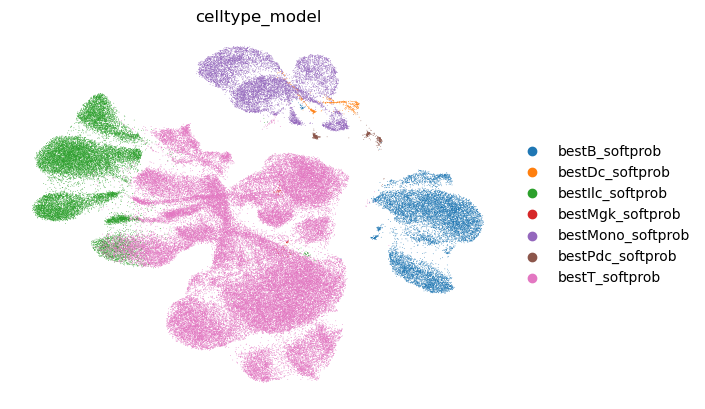

In [10]:
sc.pl.umap(
    adata,
    color=["celltype_model"],
    frameon=False,
)

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


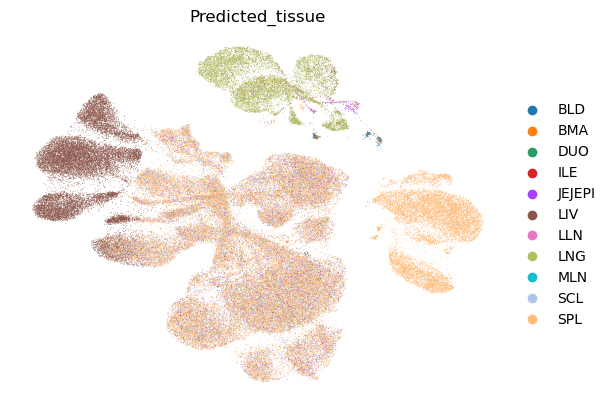

In [11]:
sc.pl.umap(
    adata,
    color=["Predicted_tissue"],
    frameon=False,
)

## UMAPS for only t cells

In [12]:
adata_t = adata[adata.obs["celltypist_cell_label_coarse"] == "T cells"]

In [13]:
# KNN calculation
sc.pp.neighbors(adata_t, n_pcs=11)
sc.tl.leiden(adata_t)
sc.tl.umap(adata_t)

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


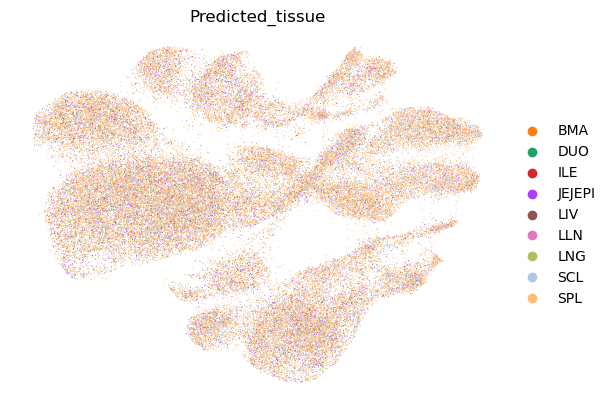

In [14]:
sc.pl.umap(
    adata_t,
    color=["Predicted_tissue"],
    frameon=False,
)

## Rank gene groups

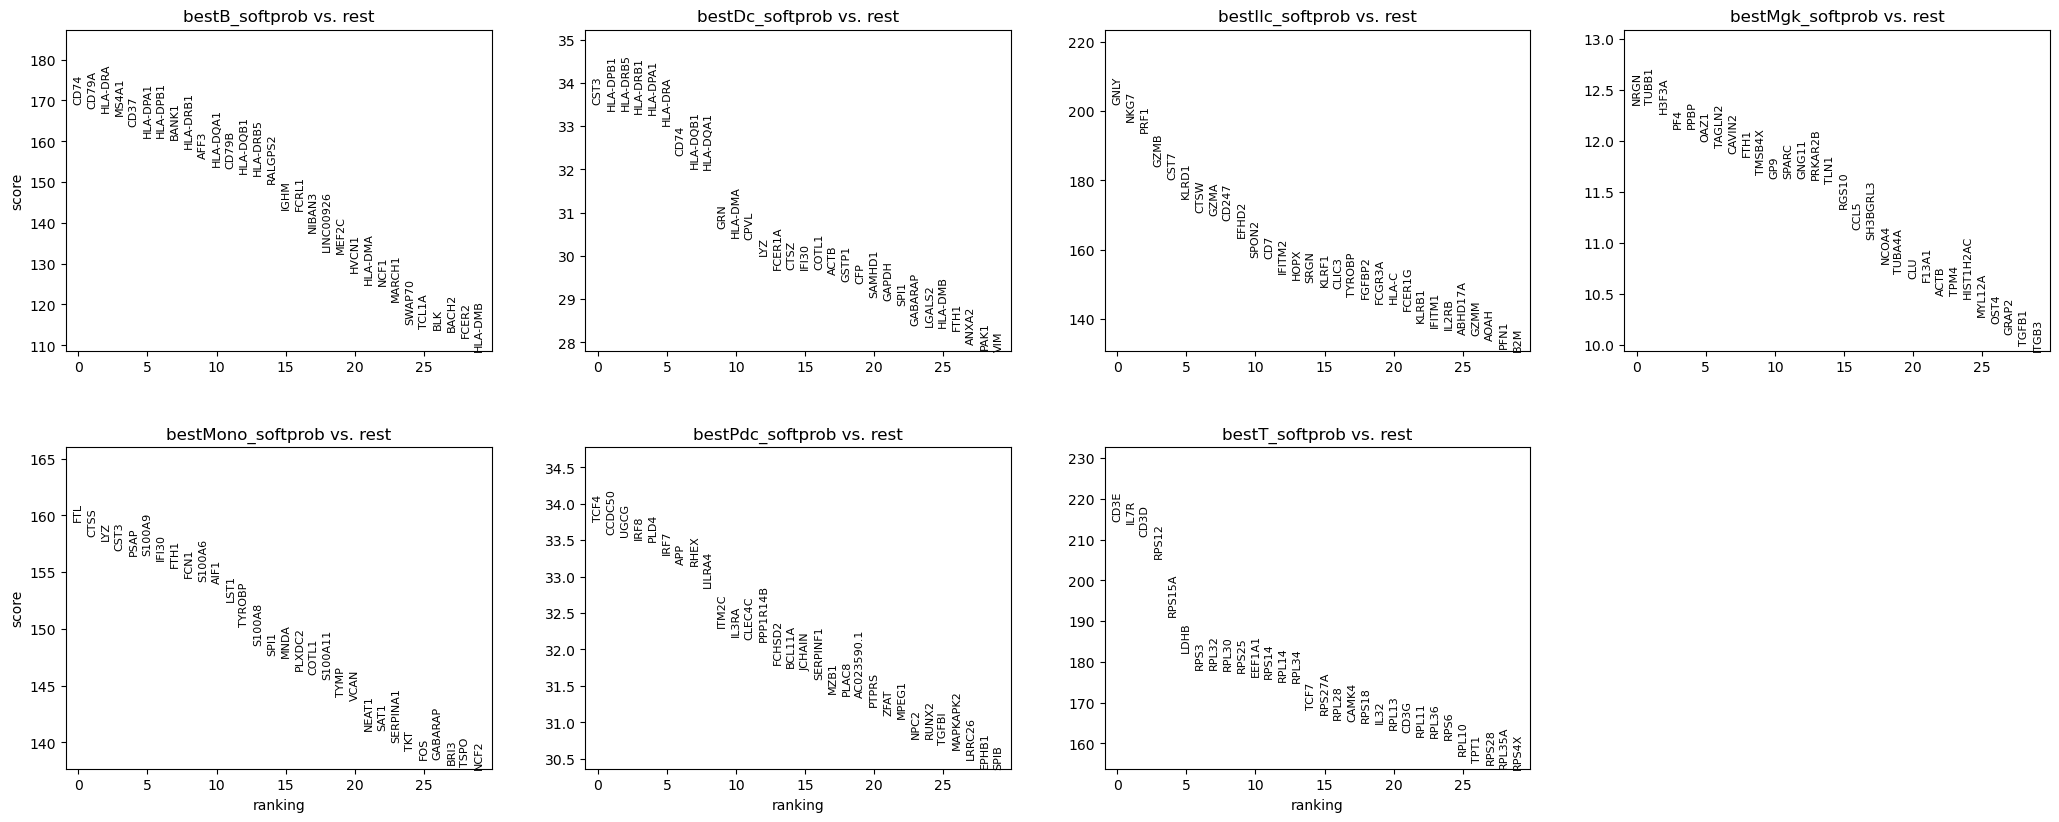

In [15]:
sc.tl.rank_genes_groups(adata, 'celltype_model', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=30, sharey=False)

Timepoint: 120a


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


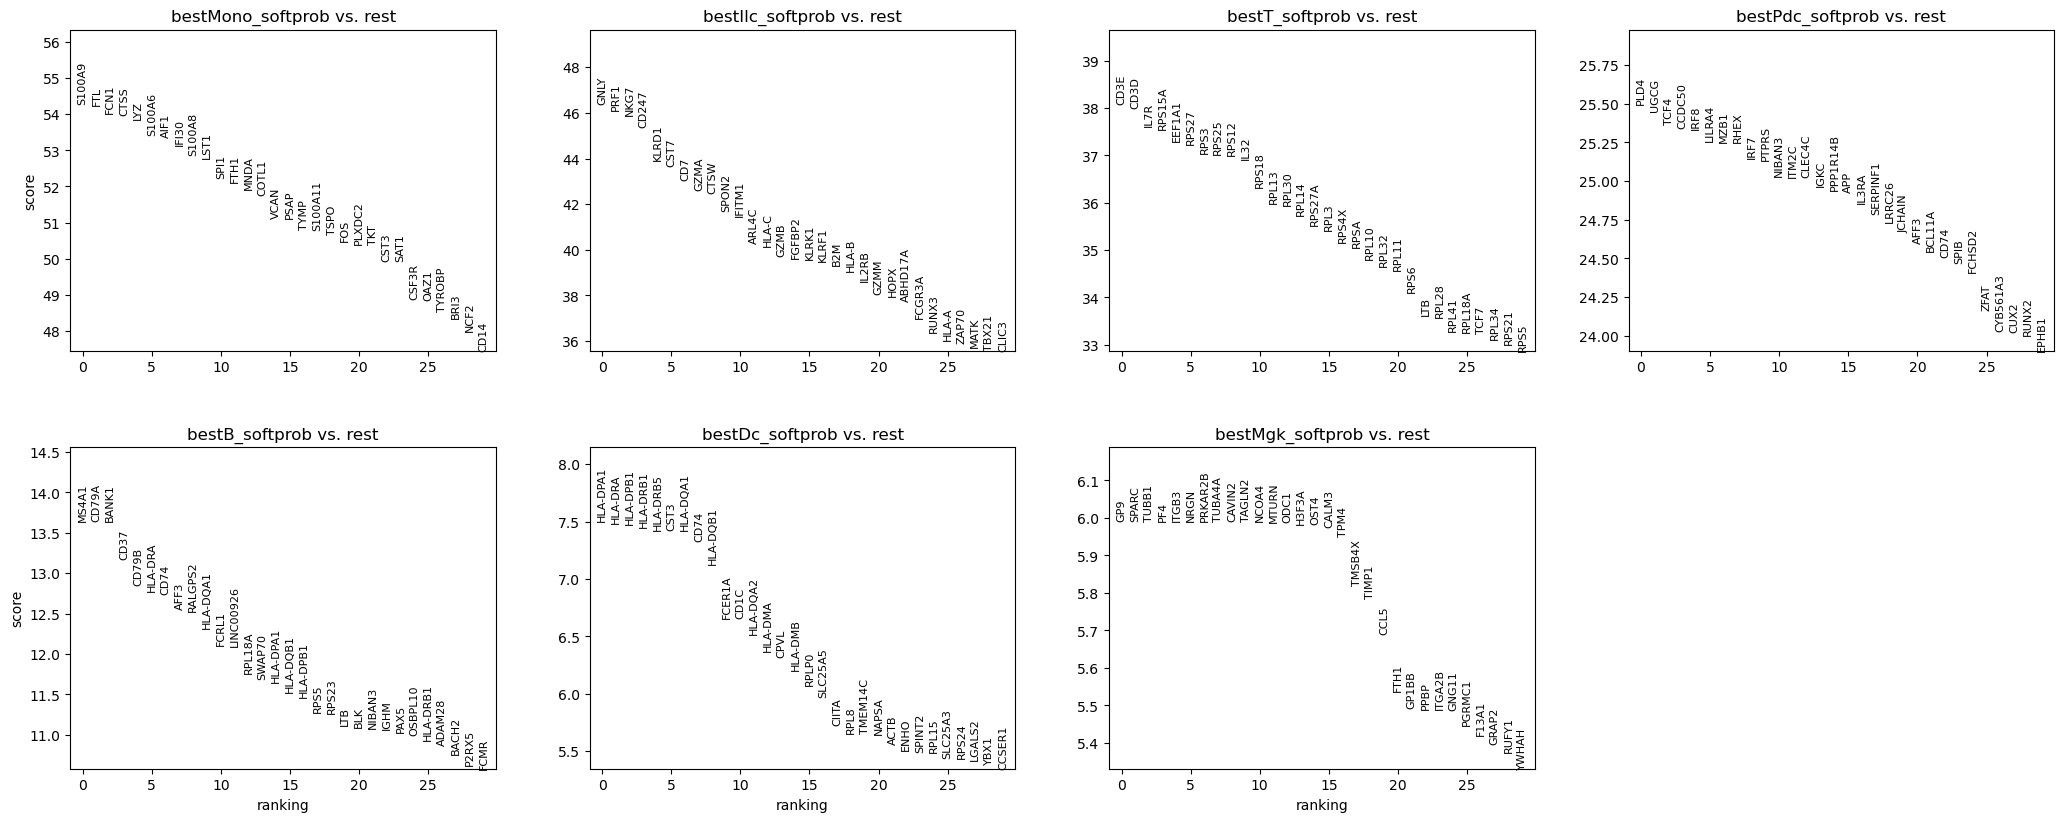

Top 5 genes for bestMono_softprob at timepoint 120a: ['S100A9' 'FTL' 'FCN1' 'CTSS' 'LYZ']
Top 5 genes for bestIlc_softprob at timepoint 120a: ['GNLY' 'PRF1' 'NKG7' 'CD247' 'KLRD1']
Top 5 genes for bestT_softprob at timepoint 120a: ['CD3E' 'CD3D' 'IL7R' 'RPS15A' 'EEF1A1']
Top 5 genes for bestPdc_softprob at timepoint 120a: ['PLD4' 'UGCG' 'TCF4' 'CCDC50' 'IRF8']
Top 5 genes for bestB_softprob at timepoint 120a: ['MS4A1' 'CD79A' 'BANK1' 'CD37' 'CD79B']
Top 5 genes for bestDc_softprob at timepoint 120a: ['HLA-DPA1' 'HLA-DRA' 'HLA-DPB1' 'HLA-DRB1' 'HLA-DRB5']
Top 5 genes for bestMgk_softprob at timepoint 120a: ['GP9' 'SPARC' 'TUBB1' 'PF4' 'ITGB3']
Timepoint: 30a


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


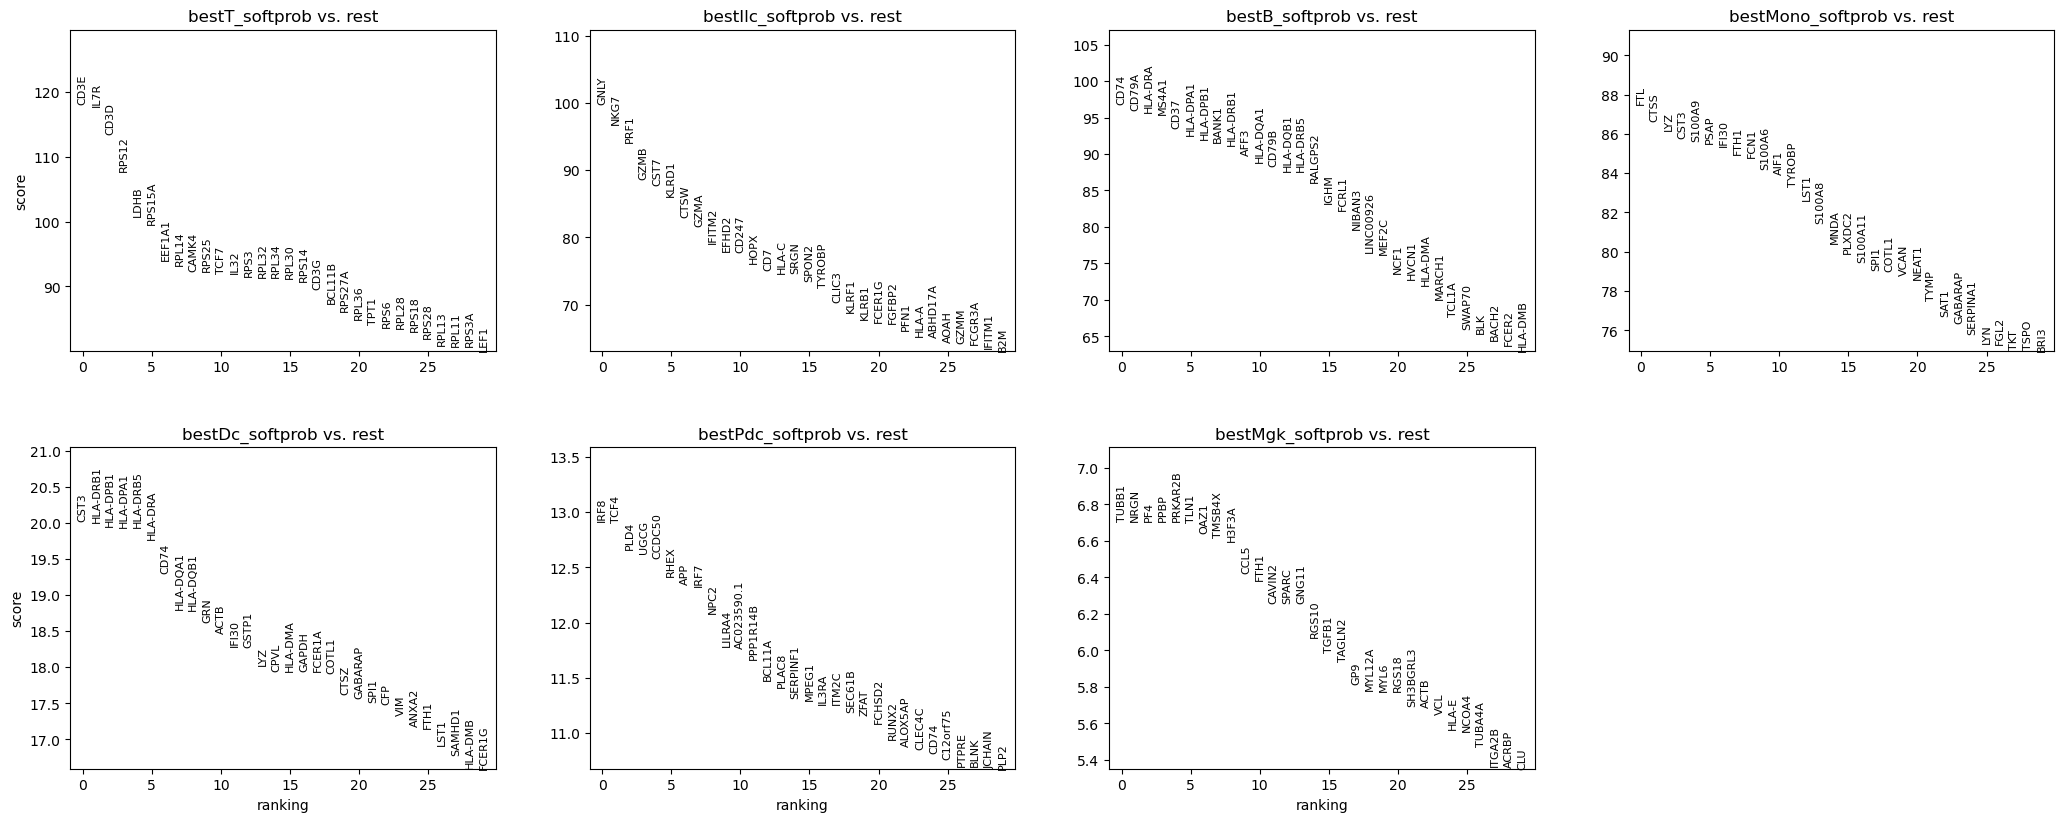

Top 5 genes for bestT_softprob at timepoint 30a: ['CD3E' 'IL7R' 'CD3D' 'RPS12' 'LDHB']
Top 5 genes for bestIlc_softprob at timepoint 30a: ['GNLY' 'NKG7' 'PRF1' 'GZMB' 'CST7']
Top 5 genes for bestB_softprob at timepoint 30a: ['CD74' 'CD79A' 'HLA-DRA' 'MS4A1' 'CD37']
Top 5 genes for bestMono_softprob at timepoint 30a: ['FTL' 'CTSS' 'LYZ' 'CST3' 'S100A9']
Top 5 genes for bestDc_softprob at timepoint 30a: ['CST3' 'HLA-DRB1' 'HLA-DPB1' 'HLA-DPA1' 'HLA-DRB5']
Top 5 genes for bestPdc_softprob at timepoint 30a: ['IRF8' 'TCF4' 'PLD4' 'UGCG' 'CCDC50']
Top 5 genes for bestMgk_softprob at timepoint 30a: ['TUBB1' 'NRGN' 'PF4' 'PPBP' 'PRKAR2B']
Timepoint: 5b


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


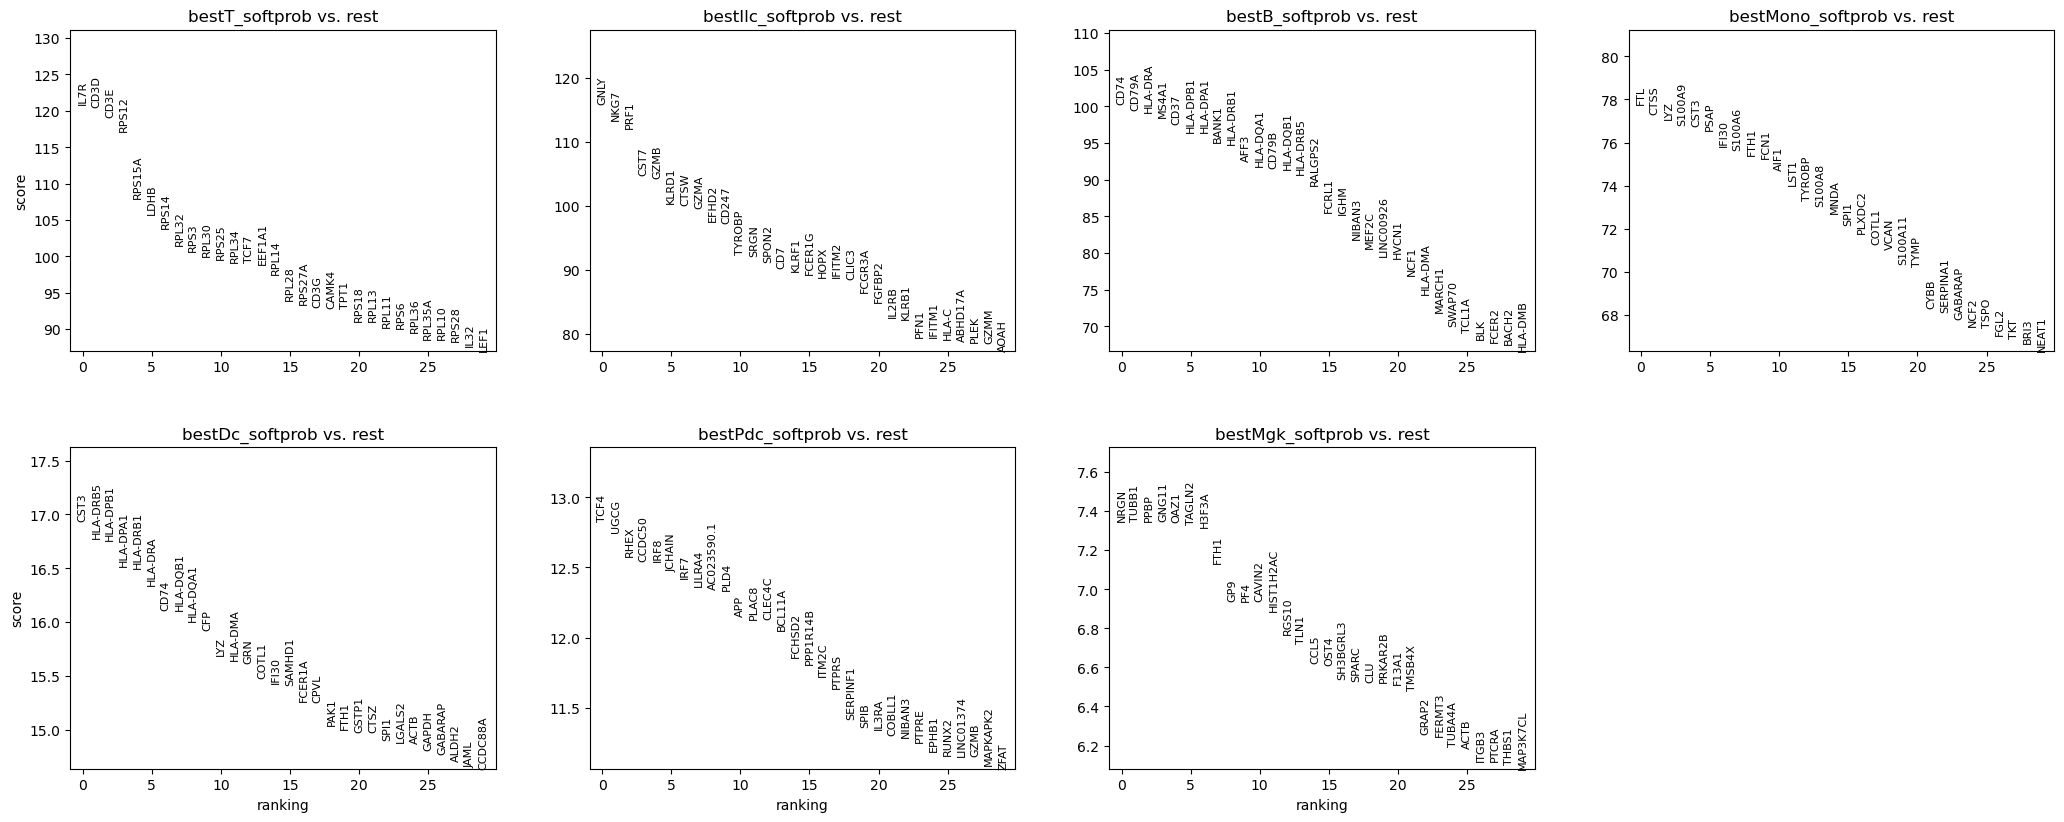

Top 5 genes for bestT_softprob at timepoint 5b: ['IL7R' 'CD3D' 'CD3E' 'RPS12' 'RPS15A']
Top 5 genes for bestIlc_softprob at timepoint 5b: ['GNLY' 'NKG7' 'PRF1' 'CST7' 'GZMB']
Top 5 genes for bestB_softprob at timepoint 5b: ['CD74' 'CD79A' 'HLA-DRA' 'MS4A1' 'CD37']
Top 5 genes for bestMono_softprob at timepoint 5b: ['FTL' 'CTSS' 'LYZ' 'S100A9' 'CST3']
Top 5 genes for bestDc_softprob at timepoint 5b: ['CST3' 'HLA-DRB5' 'HLA-DPB1' 'HLA-DPA1' 'HLA-DRB1']
Top 5 genes for bestPdc_softprob at timepoint 5b: ['TCF4' 'UGCG' 'RHEX' 'CCDC50' 'IRF8']
Top 5 genes for bestMgk_softprob at timepoint 5b: ['NRGN' 'TUBB1' 'PPBP' 'GNG11' 'OAZ1']
Timepoint: 5a


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


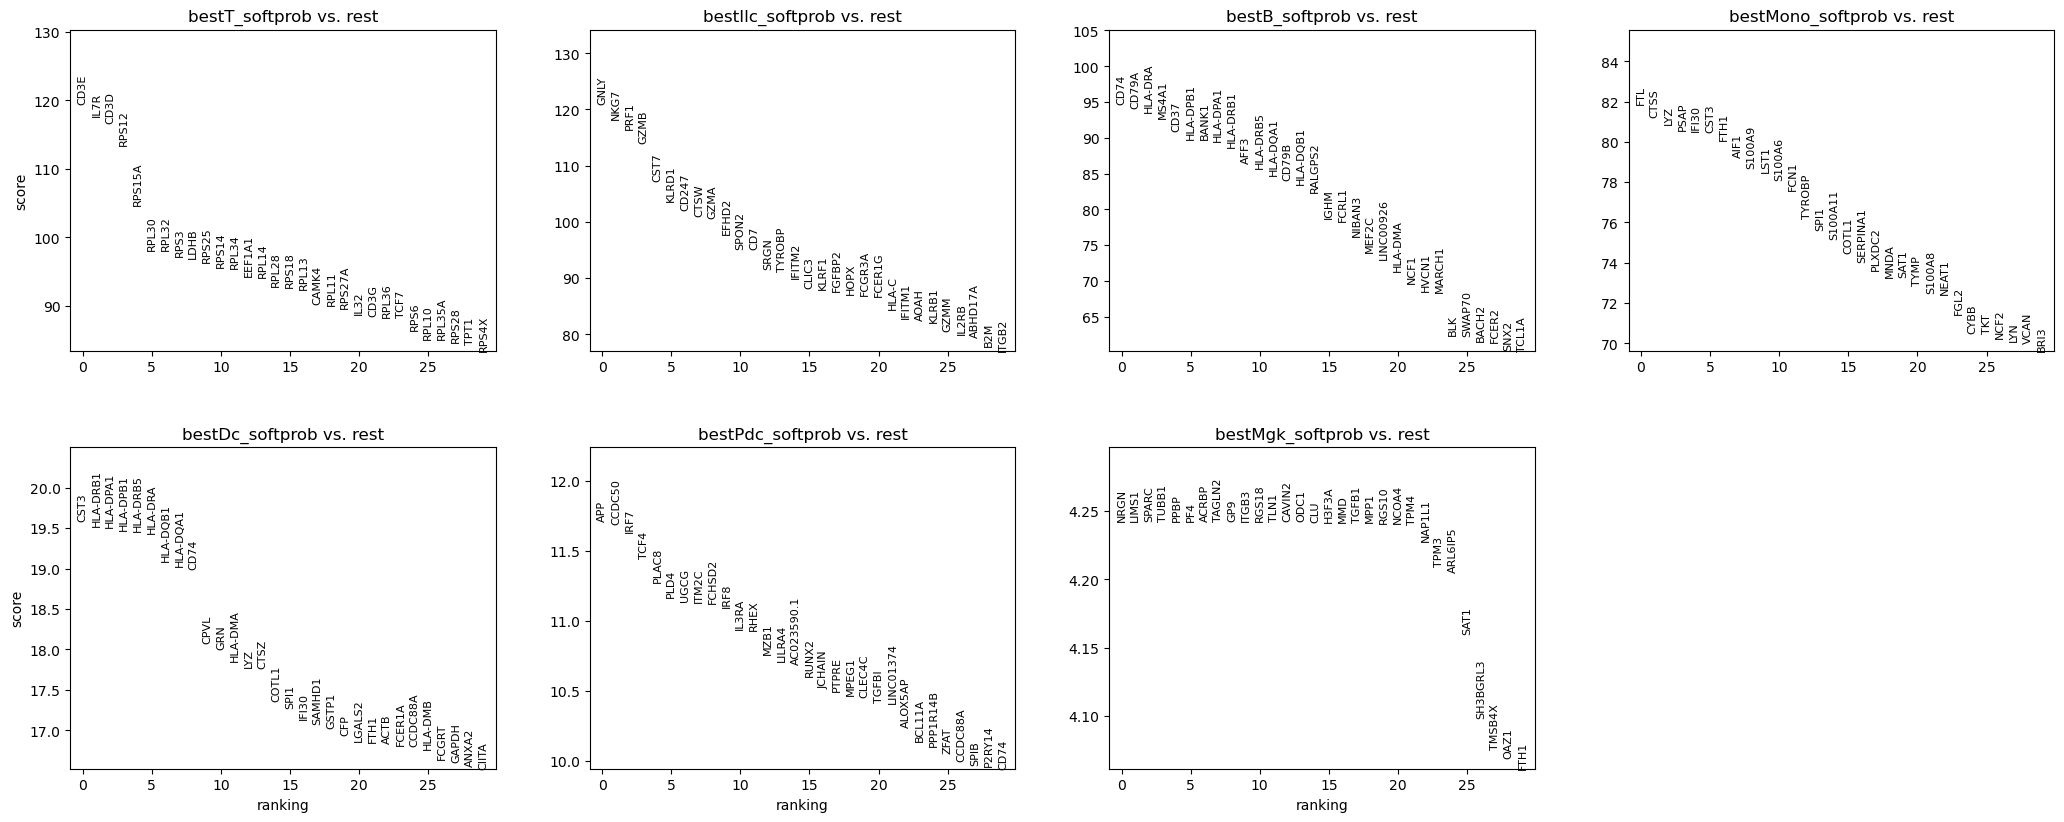

Top 5 genes for bestT_softprob at timepoint 5a: ['CD3E' 'IL7R' 'CD3D' 'RPS12' 'RPS15A']
Top 5 genes for bestIlc_softprob at timepoint 5a: ['GNLY' 'NKG7' 'PRF1' 'GZMB' 'CST7']
Top 5 genes for bestB_softprob at timepoint 5a: ['CD74' 'CD79A' 'HLA-DRA' 'MS4A1' 'CD37']
Top 5 genes for bestMono_softprob at timepoint 5a: ['FTL' 'CTSS' 'LYZ' 'PSAP' 'IFI30']
Top 5 genes for bestDc_softprob at timepoint 5a: ['CST3' 'HLA-DRB1' 'HLA-DPA1' 'HLA-DPB1' 'HLA-DRB5']
Top 5 genes for bestPdc_softprob at timepoint 5a: ['APP' 'CCDC50' 'IRF7' 'TCF4' 'PLAC8']
Top 5 genes for bestMgk_softprob at timepoint 5a: ['NRGN' 'LIMS1' 'SPARC' 'TUBB1' 'PPBP']


In [16]:
# Loop through each unique timepoint
for tp in adata.obs["timepoint"].unique():
    print(f"Timepoint: {tp}")
    
    # Subset the data for the current timepoint
    subdata = adata[adata.obs["timepoint"] == tp]
    
    # Check if there are any groups with fewer than 2 samples
    group_counts = subdata.obs['celltype_model'].value_counts()
    valid_groups = group_counts[group_counts >= 2].index.tolist()
    
    if len(valid_groups) > 0:
        # Perform differential expression analysis
        sc.tl.rank_genes_groups(subdata, 'celltype_model', groups=valid_groups, method='wilcoxon')
        
        # Plot the ranked genes
        sc.pl.rank_genes_groups(subdata, n_genes=30, sharey=False)
        
        # Extract the ranked genes
        result = subdata.uns['rank_genes_groups']
        
        # Loop through each cell type and print the top 5 genes
        for cell_type in result['names'].dtype.names:
            top_genes = result['names'][cell_type][:5]
            print(f"Top 5 genes for {cell_type} at timepoint {tp}: {top_genes}")
    else:
        print(f"No valid groups with sufficient samples at timepoint {tp}")

Timepoint: 120a


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


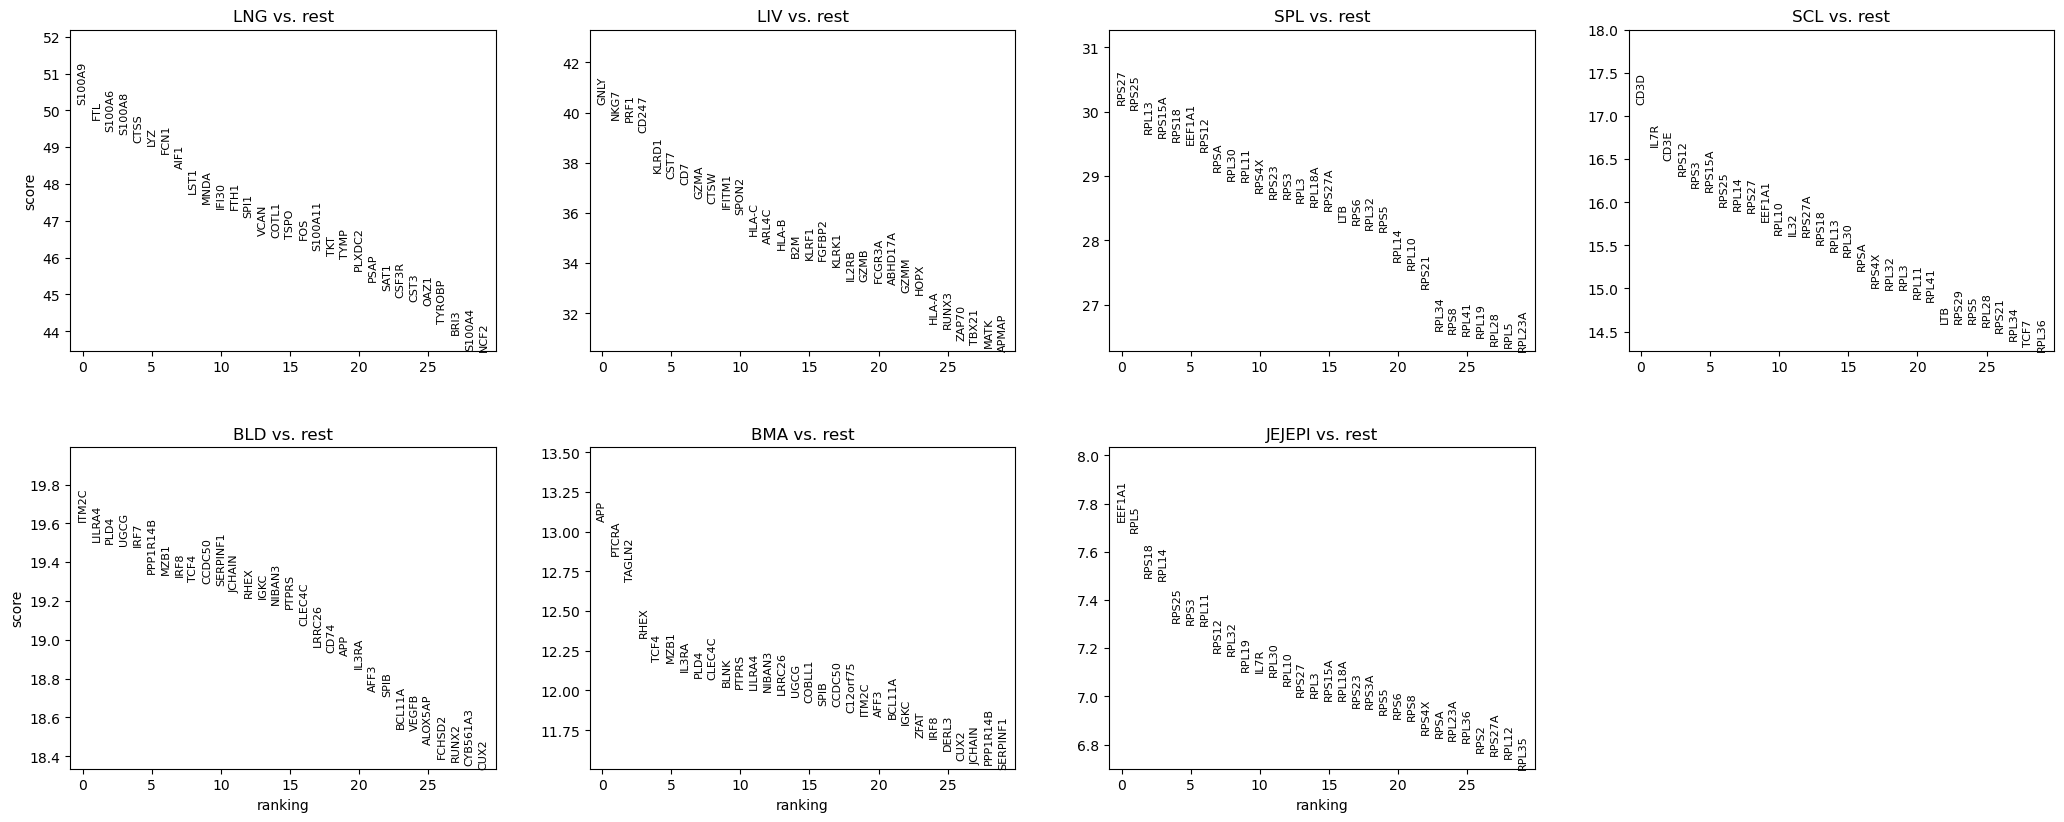

Top 5 genes for LNG at timepoint 120a: ['S100A9' 'FTL' 'S100A6' 'S100A8' 'CTSS']
Top 5 genes for LIV at timepoint 120a: ['GNLY' 'NKG7' 'PRF1' 'CD247' 'KLRD1']
Top 5 genes for SPL at timepoint 120a: ['RPS27' 'RPS25' 'RPL13' 'RPS15A' 'RPS18']
Top 5 genes for SCL at timepoint 120a: ['CD3D' 'IL7R' 'CD3E' 'RPS12' 'RPS3']
Top 5 genes for BLD at timepoint 120a: ['ITM2C' 'LILRA4' 'PLD4' 'UGCG' 'IRF7']
Top 5 genes for BMA at timepoint 120a: ['APP' 'PTCRA' 'TAGLN2' 'RHEX' 'TCF4']
Top 5 genes for JEJEPI at timepoint 120a: ['EEF1A1' 'RPL5' 'RPS18' 'RPL14' 'RPS25']
Timepoint: 30a


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


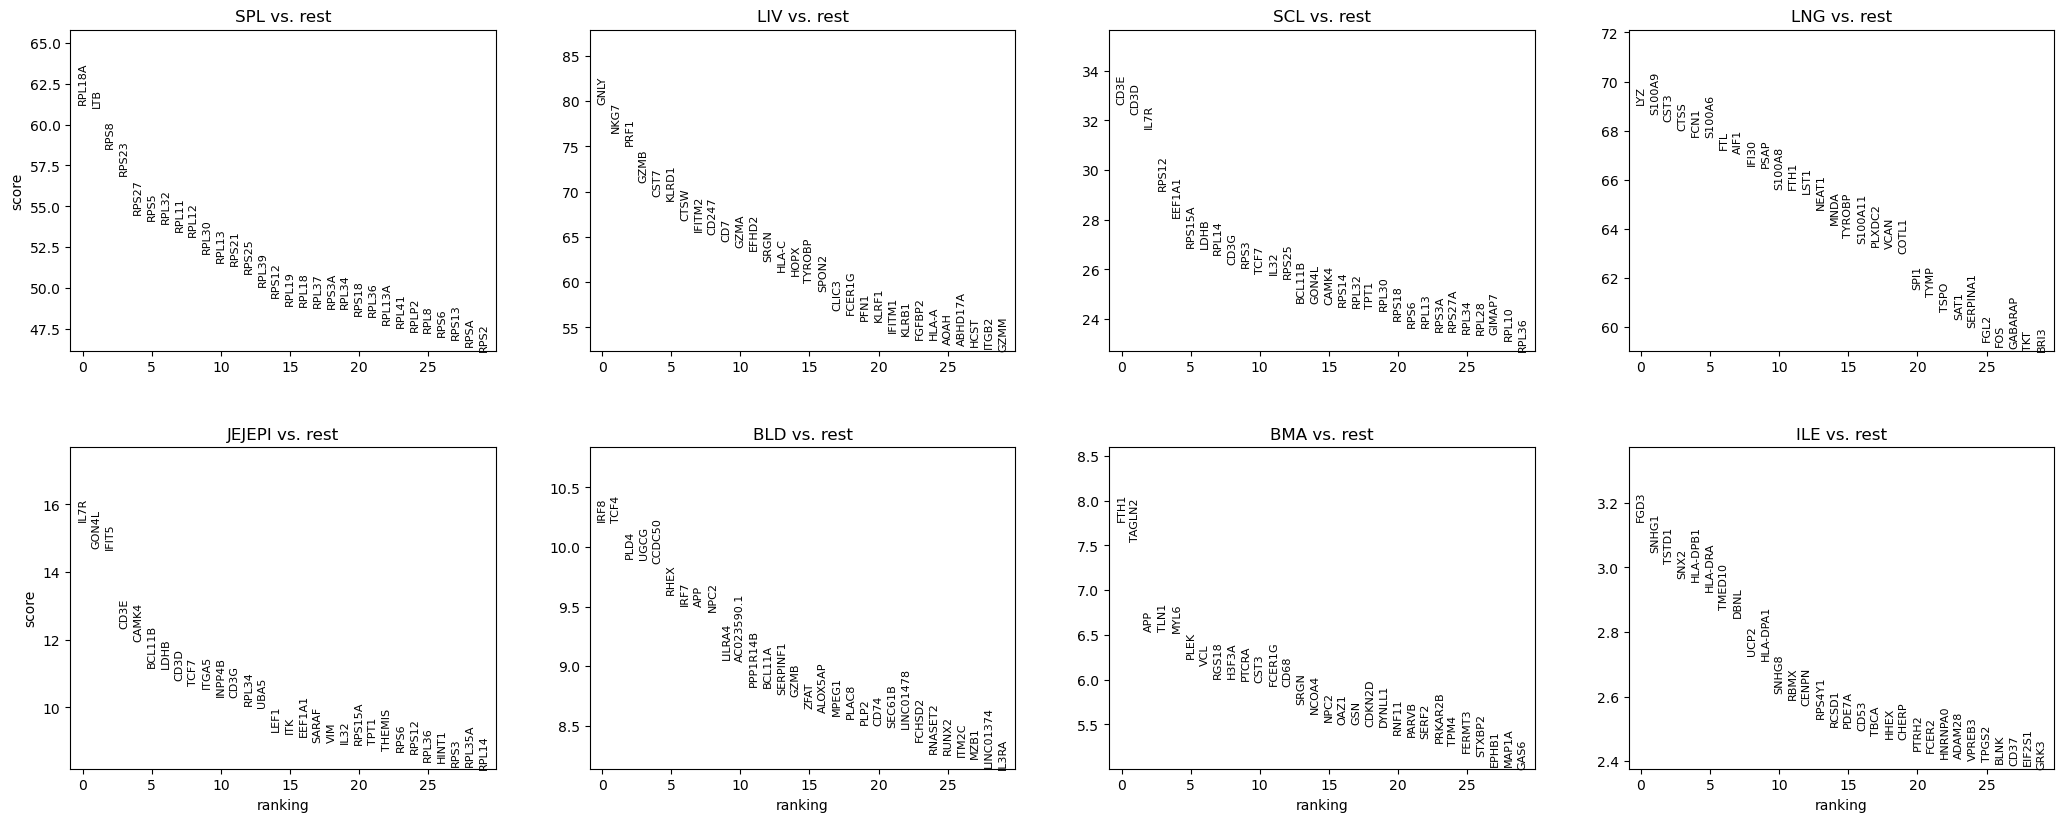

Top 5 genes for SPL at timepoint 30a: ['RPL18A' 'LTB' 'RPS8' 'RPS23' 'RPS27']
Top 5 genes for LIV at timepoint 30a: ['GNLY' 'NKG7' 'PRF1' 'GZMB' 'CST7']
Top 5 genes for SCL at timepoint 30a: ['CD3E' 'CD3D' 'IL7R' 'RPS12' 'EEF1A1']
Top 5 genes for LNG at timepoint 30a: ['LYZ' 'S100A9' 'CST3' 'CTSS' 'FCN1']
Top 5 genes for JEJEPI at timepoint 30a: ['IL7R' 'GON4L' 'IFIT5' 'CD3E' 'CAMK4']
Top 5 genes for BLD at timepoint 30a: ['IRF8' 'TCF4' 'PLD4' 'UGCG' 'CCDC50']
Top 5 genes for BMA at timepoint 30a: ['FTH1' 'TAGLN2' 'APP' 'TLN1' 'MYL6']
Top 5 genes for ILE at timepoint 30a: ['FGD3' 'SNHG1' 'TSTD1' 'SNX2' 'HLA-DPB1']
Timepoint: 5b


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


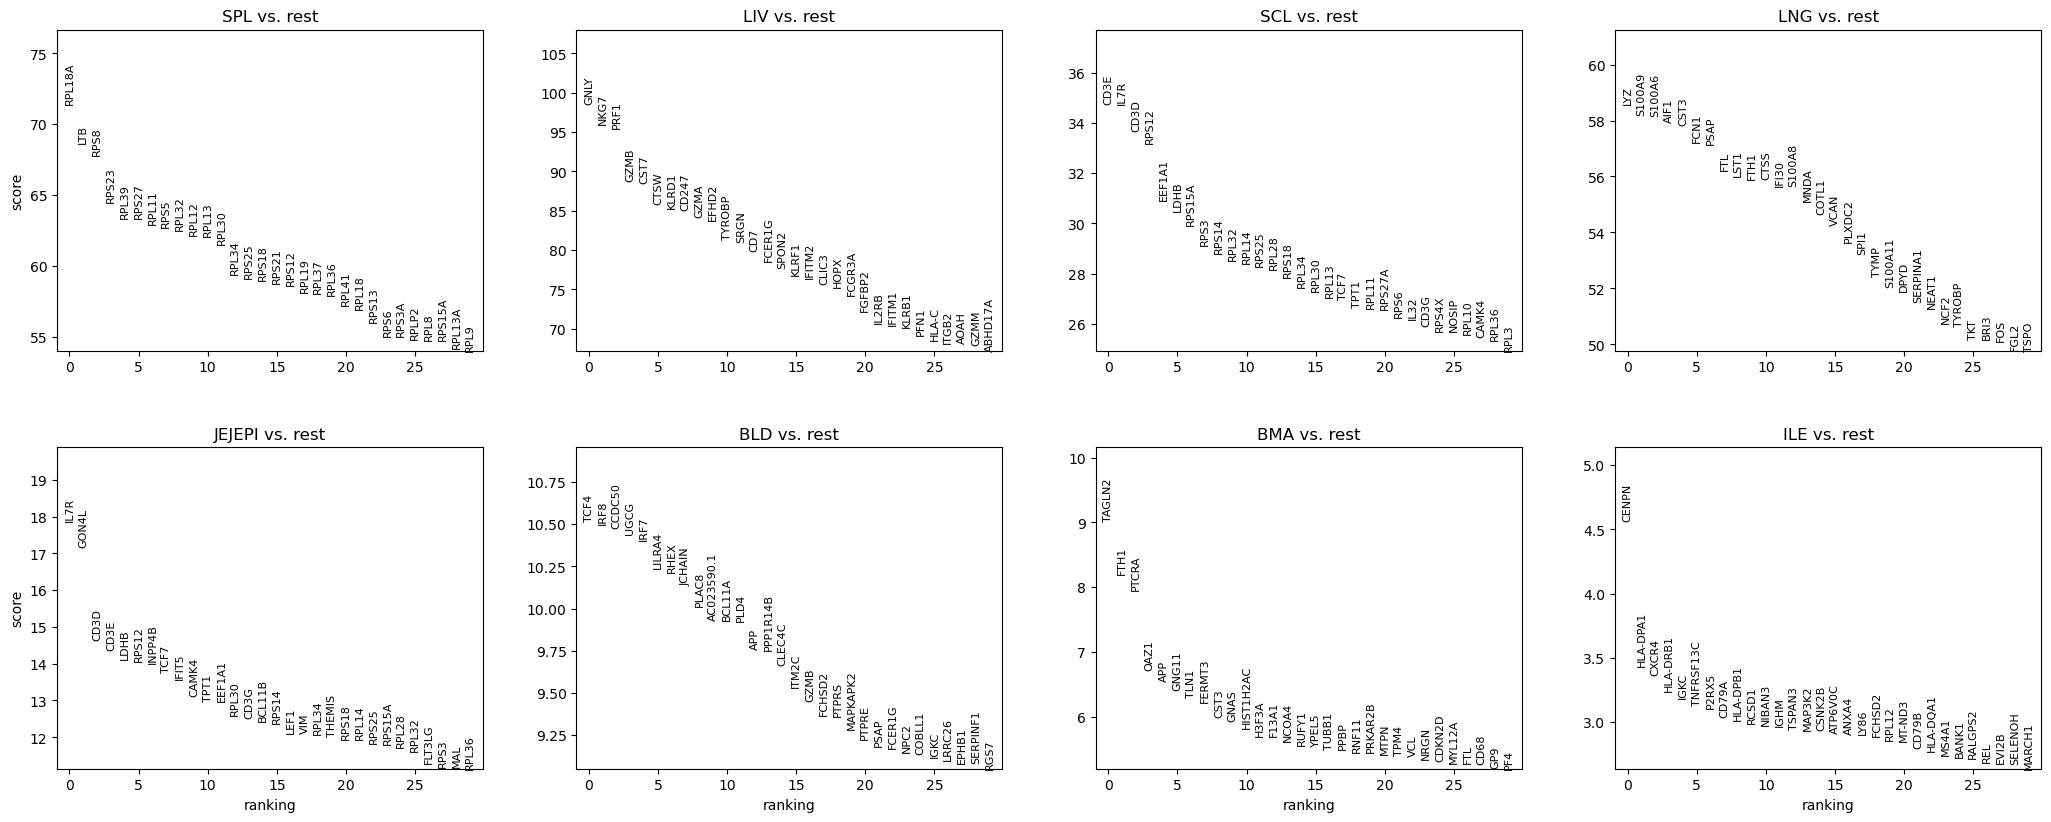

Top 5 genes for SPL at timepoint 5b: ['RPL18A' 'LTB' 'RPS8' 'RPS23' 'RPL39']
Top 5 genes for LIV at timepoint 5b: ['GNLY' 'NKG7' 'PRF1' 'GZMB' 'CST7']
Top 5 genes for SCL at timepoint 5b: ['CD3E' 'IL7R' 'CD3D' 'RPS12' 'EEF1A1']
Top 5 genes for LNG at timepoint 5b: ['LYZ' 'S100A9' 'S100A6' 'AIF1' 'CST3']
Top 5 genes for JEJEPI at timepoint 5b: ['IL7R' 'GON4L' 'CD3D' 'CD3E' 'LDHB']
Top 5 genes for BLD at timepoint 5b: ['TCF4' 'IRF8' 'CCDC50' 'UGCG' 'IRF7']
Top 5 genes for BMA at timepoint 5b: ['TAGLN2' 'FTH1' 'PTCRA' 'OAZ1' 'APP']
Top 5 genes for ILE at timepoint 5b: ['CENPN' 'HLA-DPA1' 'CXCR4' 'HLA-DRB1' 'IGKC']
Timepoint: 5a


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


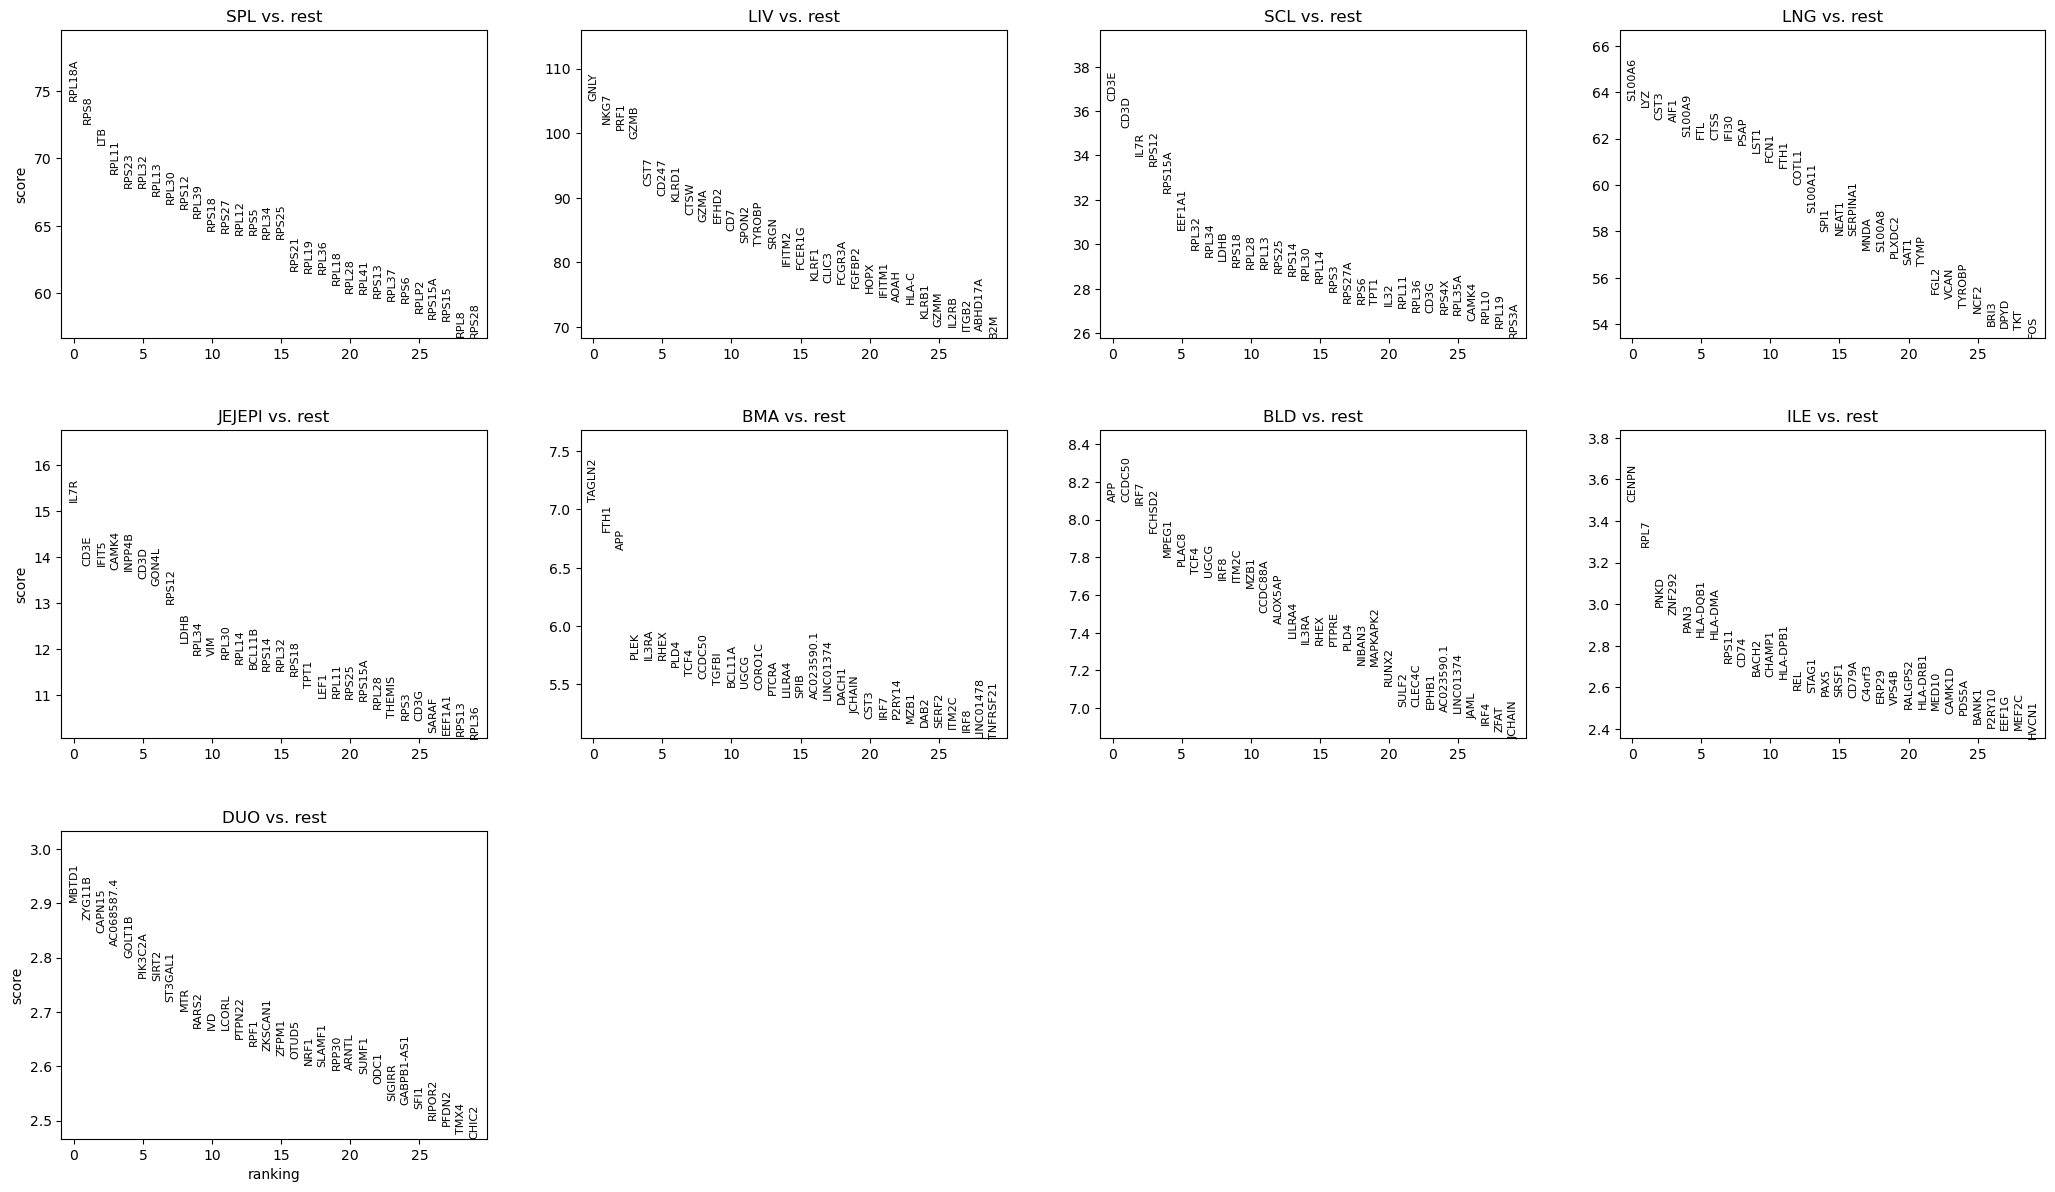

Top 5 genes for SPL at timepoint 5a: ['RPL18A' 'RPS8' 'LTB' 'RPL11' 'RPS23']
Top 5 genes for LIV at timepoint 5a: ['GNLY' 'NKG7' 'PRF1' 'GZMB' 'CST7']
Top 5 genes for SCL at timepoint 5a: ['CD3E' 'CD3D' 'IL7R' 'RPS12' 'RPS15A']
Top 5 genes for LNG at timepoint 5a: ['S100A6' 'LYZ' 'CST3' 'AIF1' 'S100A9']
Top 5 genes for JEJEPI at timepoint 5a: ['IL7R' 'CD3E' 'IFIT5' 'CAMK4' 'INPP4B']
Top 5 genes for BMA at timepoint 5a: ['TAGLN2' 'FTH1' 'APP' 'PLEK' 'IL3RA']
Top 5 genes for BLD at timepoint 5a: ['APP' 'CCDC50' 'IRF7' 'FCHSD2' 'MPEG1']
Top 5 genes for ILE at timepoint 5a: ['CENPN' 'RPL7' 'PNKD' 'ZNF292' 'PAN3']
Top 5 genes for DUO at timepoint 5a: ['MBTD1' 'ZYG11B' 'CAPN15' 'AC068587.4' 'GOLT1B']


In [17]:
# Loop through each unique timepoint
for tp in adata.obs["timepoint"].unique():
    print(f"Timepoint: {tp}")
    
    # Subset the data for the current timepoint
    subdata = adata[adata.obs["timepoint"] == tp]
    
    # Check if there are any groups with fewer than 2 samples
    group_counts = subdata.obs['Predicted_tissue'].value_counts()
    valid_groups = group_counts[group_counts >= 2].index.tolist()
    
    if len(valid_groups) > 0:
        # Perform differential expression analysis
        sc.tl.rank_genes_groups(subdata, 'Predicted_tissue', groups=valid_groups, method='wilcoxon')
        
        # Plot the ranked genes
        sc.pl.rank_genes_groups(subdata, n_genes=30, sharey=False)
        
        # Extract the ranked genes
        result = subdata.uns['rank_genes_groups']
        
        # Loop through each cell type and print the top 5 genes
        for cell_type in result['names'].dtype.names:
            top_genes = result['names'][cell_type][:5]
            print(f"Top 5 genes for {cell_type} at timepoint {tp}: {top_genes}")
    else:
        print(f"No valid groups with sufficient samples at timepoint {tp}")

categories: BLD, BMA, DUO, etc.
var_group_labels: bestB_softprob, bestDc_softprob, bestIlc_softprob, etc.


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


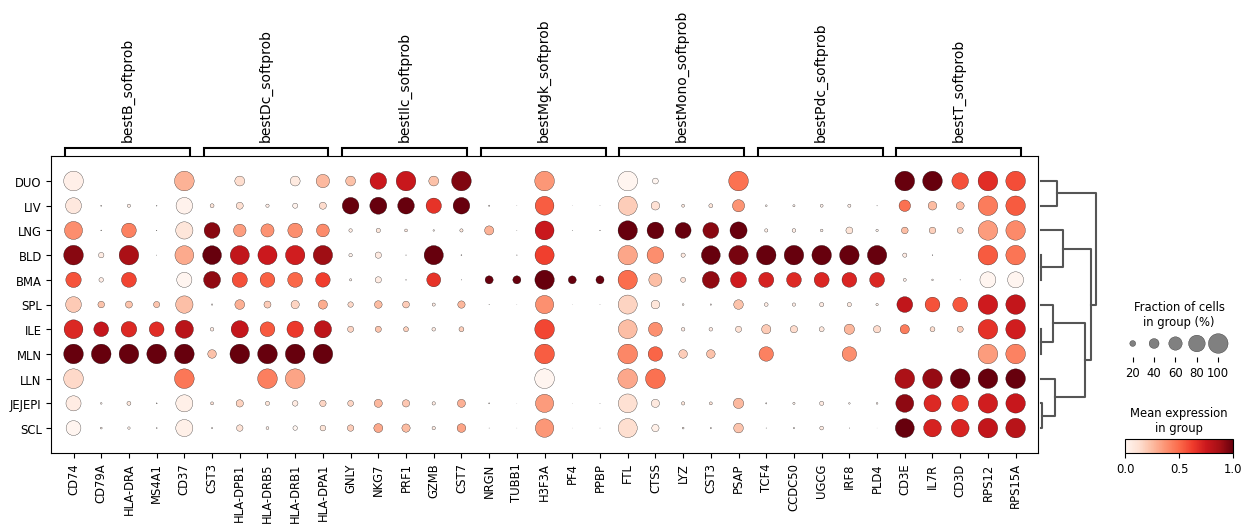

In [18]:
#For each celltype top 5 genes and their representation in the organs
sc.pl.rank_genes_groups_dotplot(adata, groupby="Predicted_tissue", n_genes=5, standard_scale='var')

Processing timepoint: 120a
categories: BLD, BMA, JEJEPI, etc.
var_group_labels: B cells, DC, ILC, etc.


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


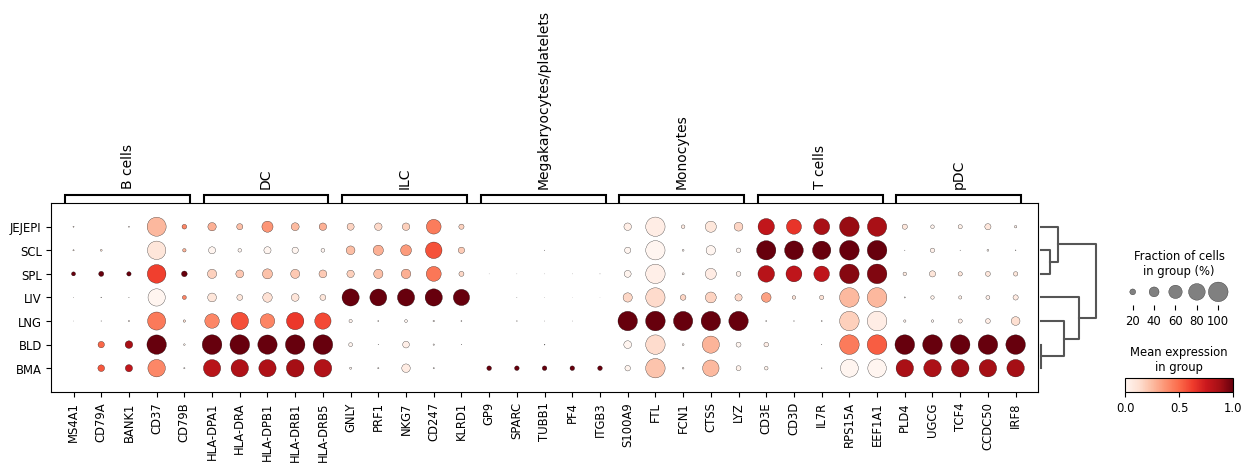

Processing timepoint: 30a
categories: BLD, BMA, DUO, etc.
var_group_labels: B cells, DC, ILC, etc.


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


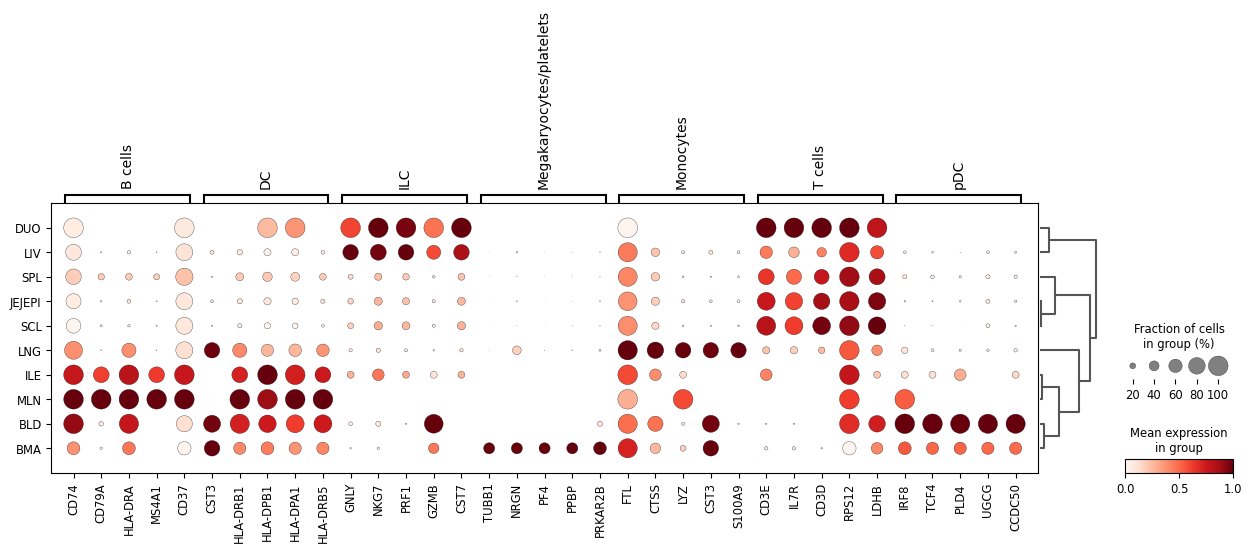

Processing timepoint: 5b
categories: BLD, BMA, DUO, etc.
var_group_labels: B cells, DC, ILC, etc.


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


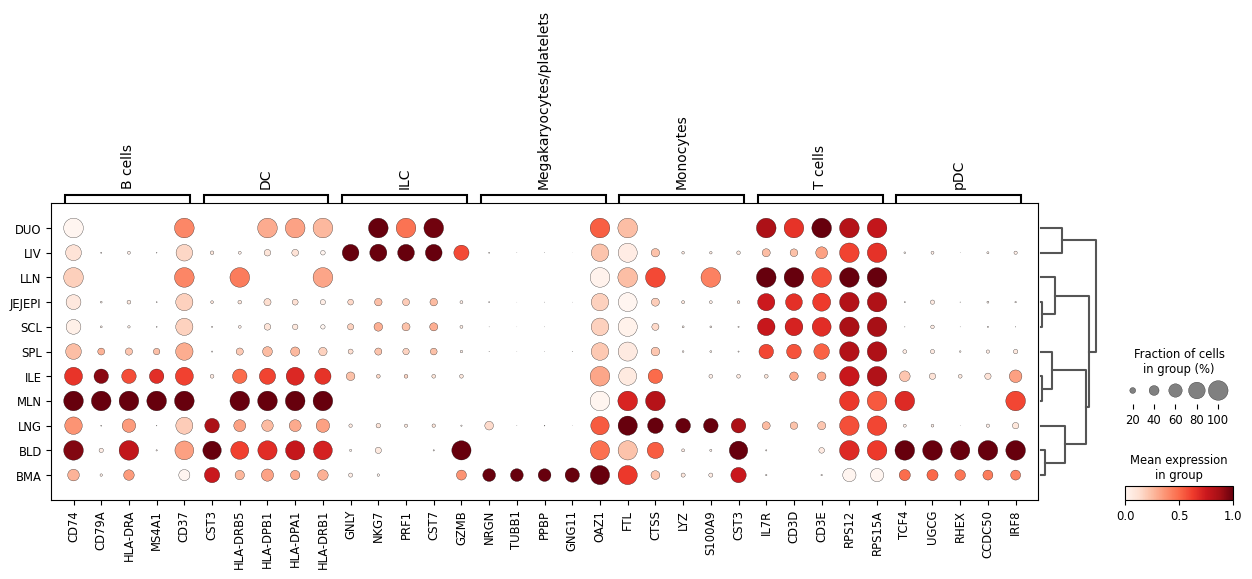

Processing timepoint: 5a
categories: BLD, BMA, DUO, etc.
var_group_labels: B cells, DC, ILC, etc.


/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


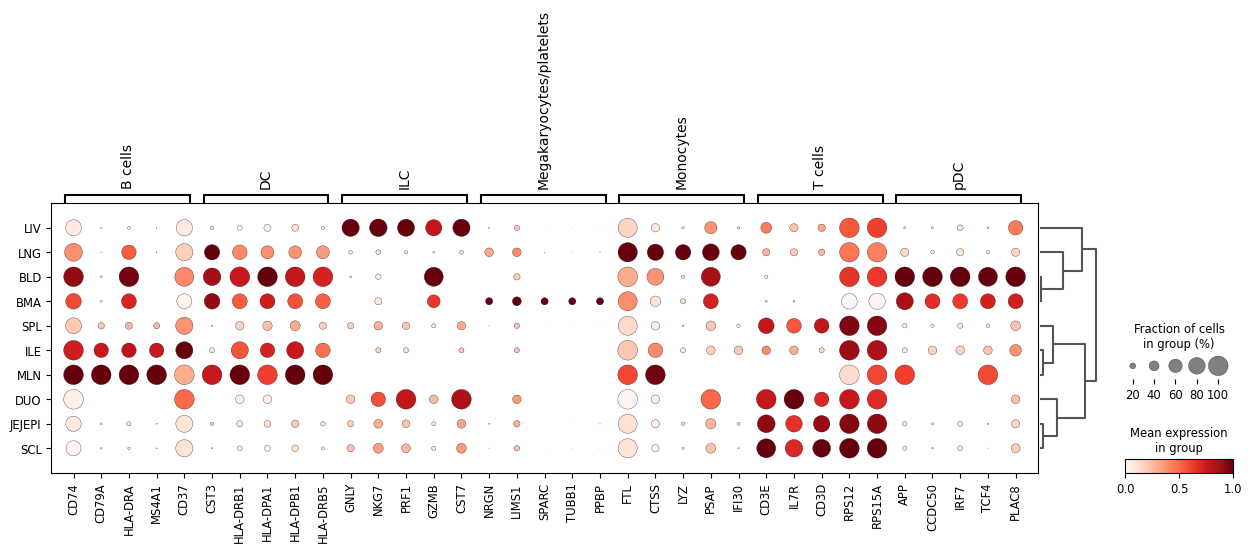

In [19]:
# Loop through each unique timepoint
for tp in adata.obs["timepoint"].unique():
    print(f"Processing timepoint: {tp}")
    
    # Create a subset for the current timepoint
    subset = adata[adata.obs["timepoint"] == tp].copy()
    
    # Perform rank genes groups analysis
    sc.tl.rank_genes_groups(subset, 'celltypist_cell_label_coarse', method='wilcoxon')
    
    # Recompute the dendrogram for the subset
    sc.tl.dendrogram(subset, groupby='Predicted_tissue')
    
    # Generate the dot plot for the top 5 genes per cell type and their representation in the organs
    sc.pl.rank_genes_groups_dotplot(subset, groupby="Predicted_tissue", n_genes=5, standard_scale='var')

# Perform a Centered Log Ratio (CLR) transformation on tissue composition per patient and then test for differences between time points using the Wilcoxon test


1. Calculate Fractions per patient and timepoint and celltype 
2. perform CLR per timepoint 
3. one Wilcoxon per celltype

In [20]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoder_organ = LabelEncoder()
y_encoded = encoder_organ.fit_transform(adata.obs["Predicted_tissue"])  # encode the organ labels

In [21]:
# Replace the existing 'Organ' column with the encoded labels
adata.obs["Organ"] = y_encoded

In [22]:
# Create a DataFrame from the AnnData object data
df = adata.obs[['celltype_model', 'Predicted_tissue', 'timepoint', 'participant']]

# Group and count the cells for each combination of celltype_model, Predicted_tissue, timepoint, and participant
counts = df.groupby(['celltype_model', 'Predicted_tissue', 'timepoint', 'participant']).size().reset_index(name='counts')

# Calculate the sum of counts per celltype_model, timepoint, and participant
timepoint_sums = counts.groupby(['celltype_model', 'timepoint', 'participant'])['counts'].transform('sum')

# To avoid NaNs, set timepoint_sums to 1 where it is 0
timepoint_sums = timepoint_sums.replace(0, 1)

# Normalize the cell counts
counts['normalized_counts'] = counts['counts'] / timepoint_sums

# Initialize an empty dictionary to hold DataFrames for each cell type
celltype_dfs = {}

# Get unique cell types
cell_types = counts['celltype_model'].unique()

# Iterate over each cell type to create separate DataFrames
for cell_type in cell_types:
    # Filter the counts DataFrame for the current cell type
    celltype_df = counts[counts['celltype_model'] == cell_type]
    
    # Pivot the table to have timepoint and participant as indices and Predicted_tissue as columns
    celltype_df_pivot = celltype_df.pivot_table(
        index=['timepoint', 'participant'], 
        columns='Predicted_tissue', 
        values='normalized_counts', 
        fill_value=0
    ).reset_index()
    
    # Store the pivoted DataFrame in the dictionary
    celltype_dfs[cell_type] = celltype_df_pivot

# Example: Accessing the DataFrame for a specific cell type
# celltype_dfs['T_cells']

# Print the resulting DataFrames for verification 
for cell_type, df in celltype_dfs.items():
    print(f"DataFrame for cell type: {cell_type}")
    print(df)
    print("\n")




DataFrame for cell type: bestB_softprob
Predicted_tissue timepoint participant  BLD  BMA  DUO       ILE  JEJEPI  \
0                       5a          P1    0    0    0  0.000000       0   
1                       5a          P2    0    0    0  0.002571       0   
2                       5a          P3    0    0    0  0.000000       0   
3                       5a          P4    0    0    0  0.000000       0   
4                       5a          P5    0    0    0  0.001422       0   
5                       5a          P6    0    0    0  0.002217       0   
6                       5a          P7    0    0    0  0.000000       0   
7                       5a          P9    0    0    0  0.000984       0   
8                       5b          P1    0    0    0  0.007042       0   
9                       5b          P2    0    0    0  0.000000       0   
10                      5b          P3    0    0    0  0.000000       0   
11                      5b          P4    0    0    0  0.000

In [23]:
from skbio.stats.composition import clr

# Function to apply CLR transformation
def apply_clr(df):
    # Select only the tissue composition columns (exclude 'timepoint' and 'participant')
    tissue_columns = df.columns.difference(['timepoint', 'participant'])
    
    # Perform CLR transformation
    clr_transformed = clr(df[tissue_columns].values + 1e-10)  # Add a small constant to avoid log(0)
    
    # Create a DataFrame for the CLR-transformed data
    clr_df = pd.DataFrame(clr_transformed, columns=tissue_columns)
    
    # Add back 'timepoint' and 'participant' columns
    clr_df['timepoint'] = df['timepoint'].values
    clr_df['participant'] = df['participant'].values
    
    return clr_df

In [25]:
# Apply CLR transformation to each DataFrame in 'celltype_dfs'
clr_transformed_dfs = {}
for cell_type, df in celltype_dfs.items():
    clr_transformed_dfs[cell_type] = apply_clr(df)

# Print the CLR-transformed DataFrames for verification
for cell_type, clr_df in clr_transformed_dfs.items():
    print(f"CLR-Transformed DataFrame for cell type: {cell_type}")
    print(clr_df)
    print("\n")

CLR-Transformed DataFrame for cell type: bestB_softprob
Predicted_tissue           BLD           BMA           DUO           ILE  \
0                -2.093259e+00 -2.093259e+00 -2.093259e+00 -2.093259e+00   
1                -5.195022e+00 -5.195022e+00 -5.195022e+00  1.186725e+01   
2                -2.093259e+00 -2.093259e+00 -2.093259e+00 -2.093259e+00   
3                -2.093259e+00 -2.093259e+00 -2.093259e+00 -2.093259e+00   
4                -5.187250e+00 -5.187250e+00 -5.187250e+00  1.128324e+01   
5                -3.630729e+00 -3.630729e+00 -3.630729e+00  1.328366e+01   
6                -2.093259e+00 -2.093259e+00 -2.093259e+00 -2.093259e+00   
7                -6.630458e+00 -6.630458e+00 -6.630458e+00  9.471764e+00   
8                -3.735346e+00 -3.735346e+00 -3.735346e+00  1.433468e+01   
9                -5.159174e+00 -5.159174e+00 -5.159174e+00 -5.159174e+00   
10               -2.093259e+00 -2.093259e+00 -2.093259e+00 -2.093259e+00   
11               -3.553759e+00 -

In [26]:
# Function to perform Wilcoxon test
def perform_wilcoxon(df):
    tissue_columns = df.columns.difference(['timepoint', 'participant'])
    
    # Collect results
    results = []
    
    # Define specific timepoint pairs to compare
    comparisons = [('5b', '5a'), ('5a', '30a'), ('30a', '120a')]
    
    # Perform pairwise Wilcoxon test for specific timepoint pairs
    for timepoint_1, timepoint_2 in comparisons:
        for tissue in tissue_columns:
            data_1 = df[df['timepoint'] == timepoint_1][tissue]
            data_2 = df[df['timepoint'] == timepoint_2][tissue]
            
            if len(data_1) == len(data_2):  # Ensure equal lengths for Wilcoxon test
                stat, p_value = wilcoxon(data_1, data_2)
                
                results.append({
                    'Tissue': tissue,
                    'Timepoint_1': timepoint_1,
                    'Timepoint_2': timepoint_2,
                    'Combination': f'{timepoint_1} vs {timepoint_2}',
                    'Statistic': stat,
                    'P-value': p_value
                })
    
    return pd.DataFrame(results)

In [29]:
# Apply Wilcoxon test to each CLR-transformed DataFrame
wilcoxon_results = {}
for cell_type, df in clr_transformed_dfs.items():
    wilcoxon_results[cell_type] = perform_wilcoxon(df)

/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/jkuhn/miniconda3/envs/xgboost/lib/python3.8/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [30]:
# Filter significant results for each cell type and print them
for cell_type, results_df in wilcoxon_results.items():
    significant_results_df = results_df[results_df['P-value'] < 0.05]
    print(f"Significant results for {cell_type}:")
    print(significant_results_df)
    print("\n")

Significant results for bestB_softprob:
    Tissue Timepoint_1 Timepoint_2  Combination  Statistic   P-value
22     BLD         30a        120a  30a vs 120a        0.0  0.017960
23     BMA         30a        120a  30a vs 120a        0.0  0.017960
24     DUO         30a        120a  30a vs 120a        0.0  0.017960
26  JEJEPI         30a        120a  30a vs 120a        0.0  0.017960
27     LIV         30a        120a  30a vs 120a        1.0  0.027992
28     LLN         30a        120a  30a vs 120a        0.0  0.017960
29     LNG         30a        120a  30a vs 120a        0.0  0.017960
31     SCL         30a        120a  30a vs 120a        0.0  0.017960
32     SPL         30a        120a  30a vs 120a        1.0  0.027992


Significant results for bestDc_softprob:
    Tissue Timepoint_1 Timepoint_2  Combination  Statistic   P-value
22     BLD         30a        120a  30a vs 120a        1.0  0.015625
23     BMA         30a        120a  30a vs 120a        1.0  0.015625
24     DUO         3

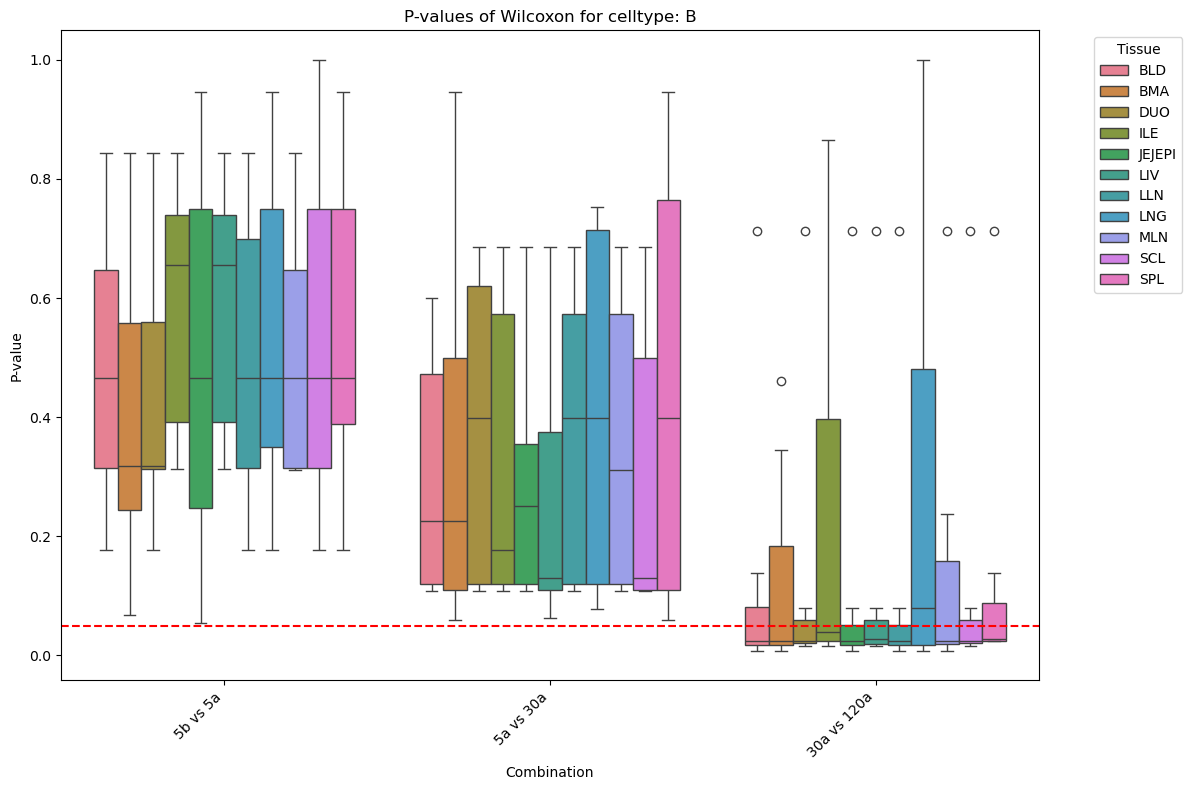

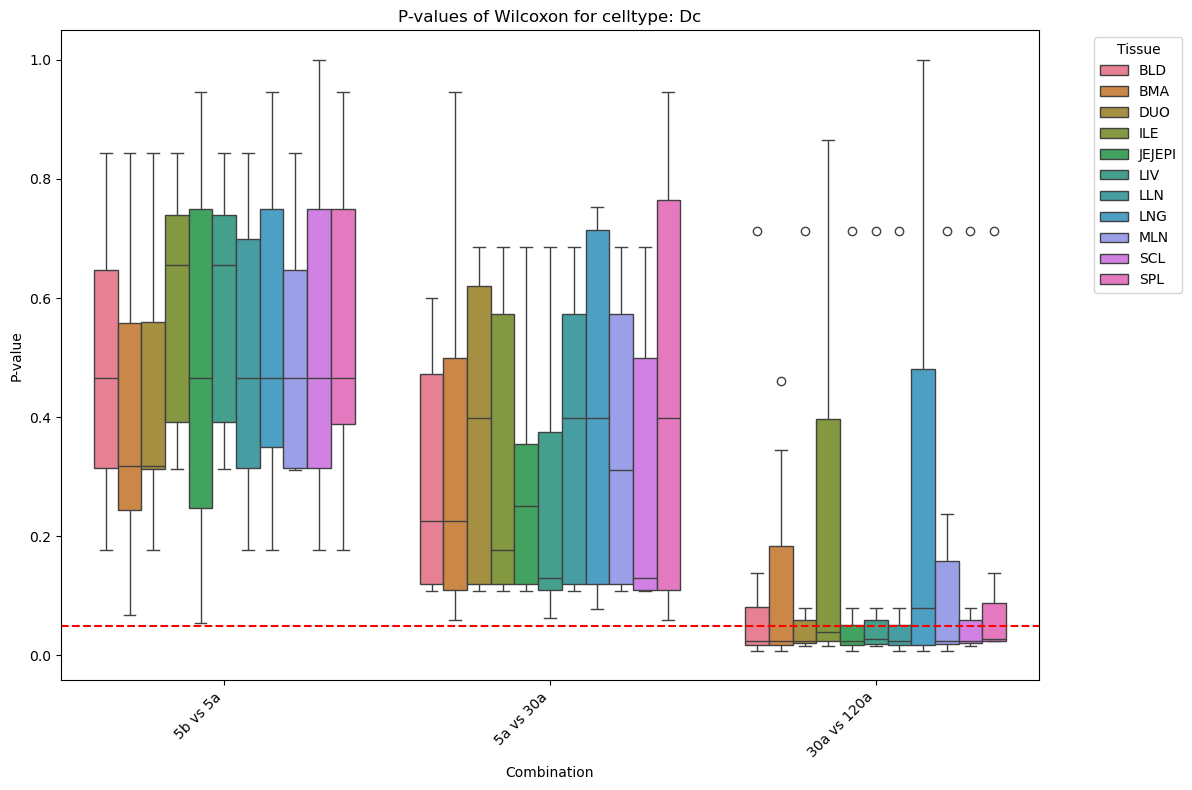

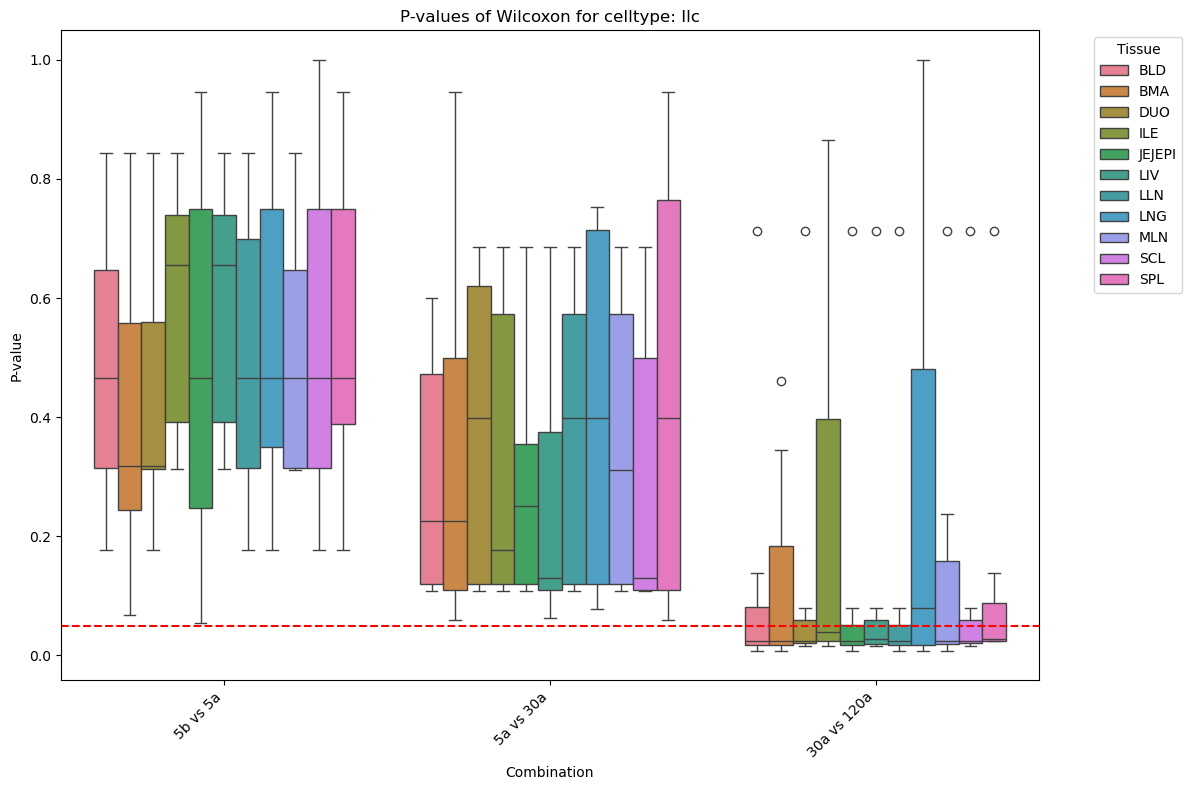

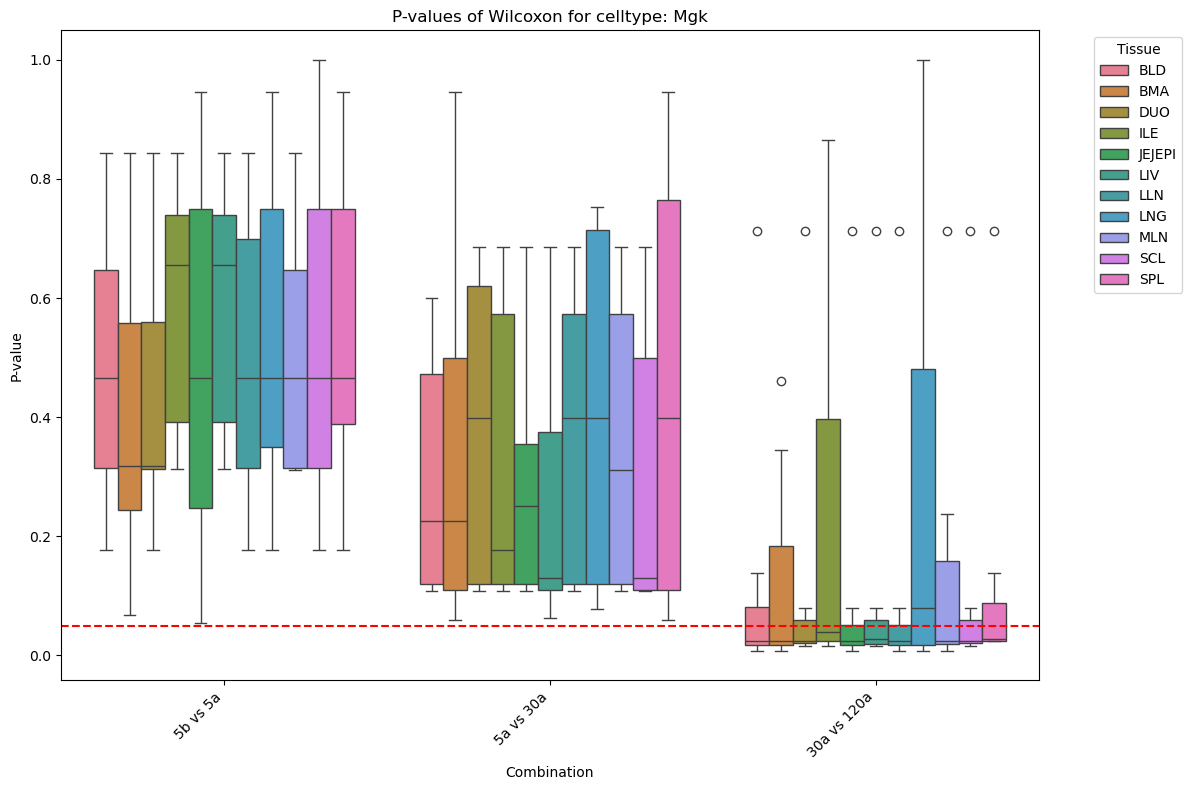

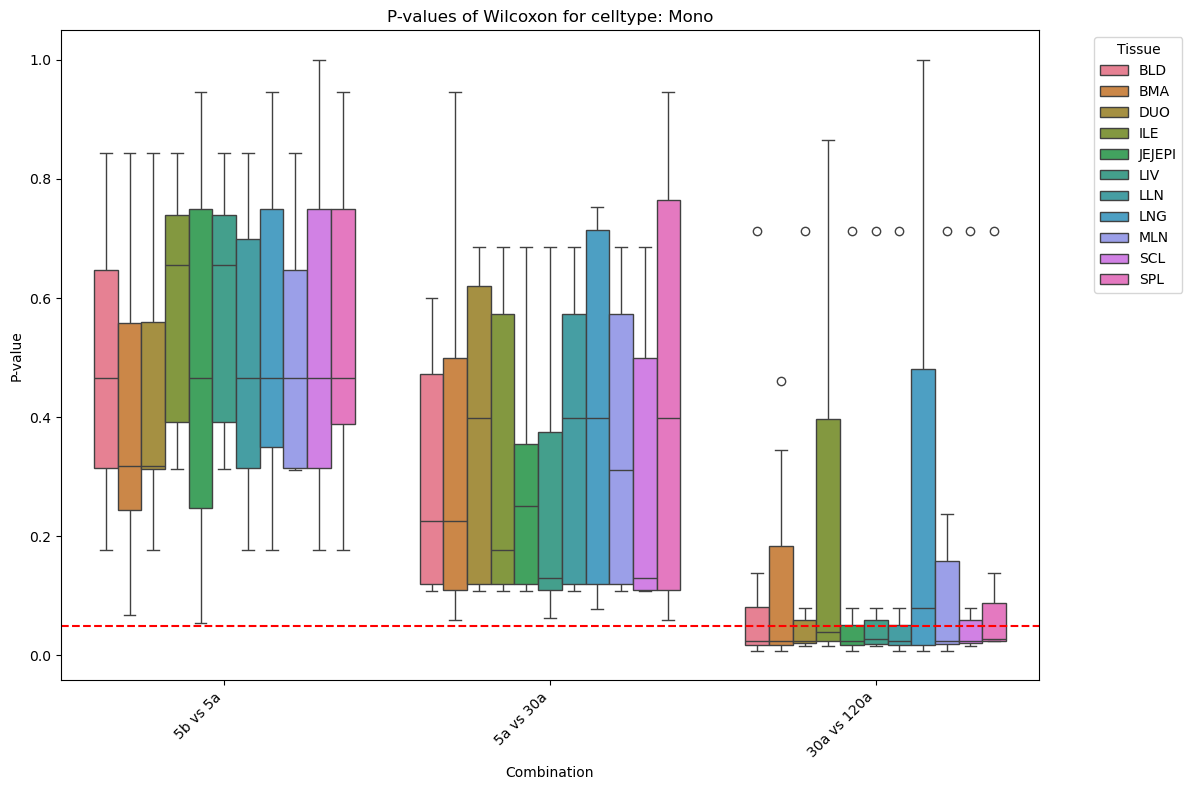

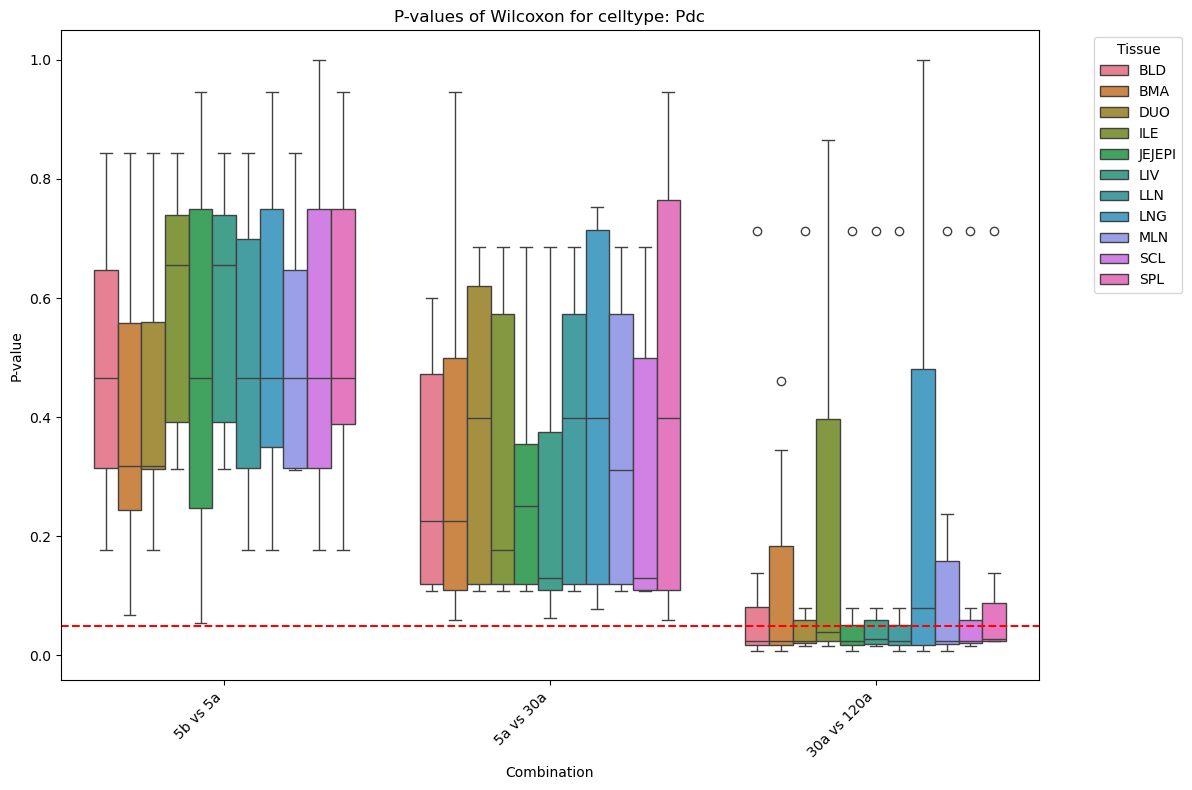

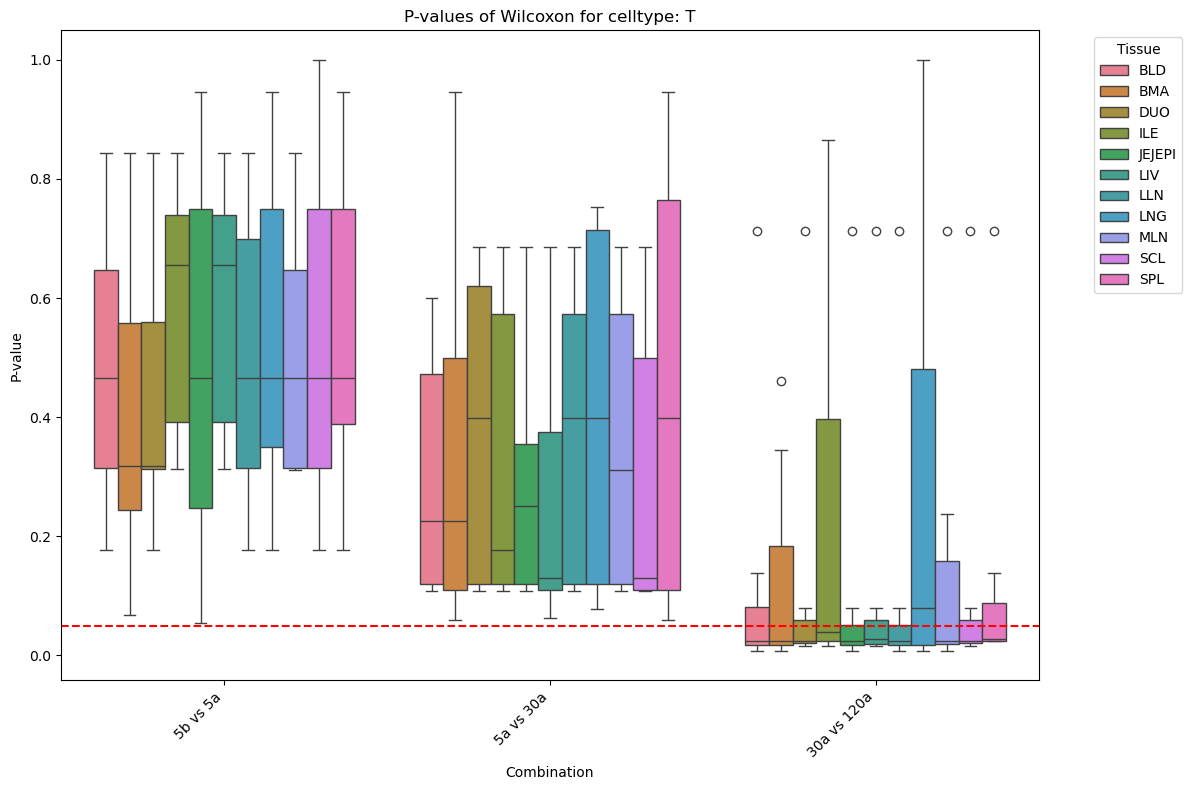

In [34]:
# plot the resulting wilcoxon results
# Concatenate results for all cell types
all_results = pd.concat(wilcoxon_results.values())


for cell_type, results_df in wilcoxon_results.items():
    cell_type_short = cell_type.split('_')[0]
    cell_type_short = cell_type_short.split('best')[1]
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Combination', y='P-value', hue='Tissue', data=all_results)
    plt.title(f'P-values of Wilcoxon for celltype: {cell_type_short}')
    plt.xlabel('Combination')
    plt.ylabel('P-value')
    plt.axhline(y=0.05, color='red', linestyle='--')  # Add a line for significance threshold
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.legend(title='Tissue', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside plot
    plt.tight_layout()
    plt.show()